In [2]:
import skysurvey
import numpy as np
import sncosmo
from scipy.ndimage import gaussian_filter
from scipy.spatial import cKDTree
import corner
import pandas
from code import *
from tqdm.notebook import tqdm
import time
import healpy
import jax.numpy as jnp
import pickle

In [3]:
import warnings
from iminuit.warnings import IMinuitWarning
warnings.filterwarnings('ignore', category=IMinuitWarning) 

In [4]:
%matplotlib inline

In [5]:
import logging

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
stream_handler = logging.StreamHandler()
stream_handler.setFormatter(logging.Formatter(
    '%(asctime)s %(levelname)-8s: %(message)s', datefmt='%H:%M'))

stream_handler.setLevel(logging.INFO)
logger.addHandler(stream_handler)

file_handler = logging.FileHandler('logs.txt', mode='a')
file_handler.setFormatter(logging.Formatter(
    '%(asctime)s %(levelname)-8s: %(message)s', datefmt='%Y/%m/%d %H:%M'))

file_handler.setLevel(logging.DEBUG)
logger.addHandler(file_handler)

In [6]:
%load_ext line_profiler

# skysurvey tests

In [4]:
snia = skysurvey.SNeIa()

In [5]:
data = snia.draw(size=10_000, inplace=True)

In [ ]:
scatter_mollweide(data)

In [ ]:
fig = corner_(
    snia.data,
    var_names=["z", "x1", "c", "ra", "dec", "magabs", "magobs"],
    labels=[r"$z$", r"$x_1$", r"$c$", r"RA", r"DEC", r"$M_{abs}$", r"$M_{obs}$"],
    title='Distribution des SN',
)

In [8]:
import pickle

with open('data/ztf_survey.pkl','rb') as file:
    survey = pickle.load(file)

In [9]:
dset = skysurvey.DataSet.from_targets_and_survey(snia, survey)

/global/homes/a/agillesl/.local/perlmutter/python-3.11/lib/python3.11/site-packages/ztffields/projection.py:157: UserWarning: cannot use dask_geopandas with MultiIndex fields dataframe
  warnings.warn("cannot use dask_geopandas with MultiIndex fields dataframe")
100%|██████████| 18648/18648 [01:07<00:00, 274.30it/s] 
/global/homes/a/agillesl/.local/perlmutter/python-3.11/lib/python3.11/site-packages/skysurvey/dataset.py:154: FutureWarning: The behavior of pd.concat with len(keys) != len(objs) is deprecated. In a future version this will raise instead of truncating to the smaller of the two sequences
  data = pandas.concat(lightcurves, keys=fieldids # store fieldid


In [ ]:
index = dset_sanitize_and_filter(dset)

In [36]:
import logging
logger = logging.getLogger(__name__)
logging.basicConfig(filename='test.log', encoding='utf-8', level=logging.DEBUG)

In [38]:
from tqdm.contrib.logging import logging_redirect_tqdm
with logging_redirect_tqdm():
    for i in tqdm(range(9)):
        if i == 4:
            logger.info("console logging redirected to `tqdm.write()`")
# logging restored

  0%|          | 0/9 [00:00<?, ?it/s]

In [ ]:
fig = corner.corner(
    dset.targets.data.loc[detected],
    var_names=["z", "x0", "x1", "c", "ra", "dec", "magabs", "magobs"],
    show_titles=True,
    bins=20,
    smooth=0.9,
    quantiles=None,
    label_kwargs=dict(fontsize=16),
    title_kwargs=dict(fontsize=16),
    color="b",
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.0)),
    plot_density=False,
    plot_datapoints=True,
    fill_contours=True,
    max_n_ticks=7,
    hist_kwargs=dict(density=True, color="b"),
    labels=[
        r"$z$",
        r"$x_0$",
        r"$x_1$",
        r"$c$",
        r"RA",
        r"DEC",
        r"$MAGABS$",
        r"$MAGOBS$",
    ],
    alpha=0.2,
)
fig.suptitle('Distribution des SN détectées', fontsize=30)

In [ ]:
_ = dset.show_target_lightcurve(index=index[26])

In [ ]:
fixed = {"z": dset.targets.data.loc[detected]["z"]}

guess = {
    "t0": dset.targets.data.loc[detected]["t0"],
    "c": dset.targets.data.loc[detected]["c"],
    "x0": dset.targets.data.loc[detected]["x0"],
    "x1": dset.targets.data.loc[detected]["x1"],
}
bounds = {
    "t0": dset.targets.data.loc[detected]["t0"].apply(lambda x: [x-5, x+5]),
    "c": dset.targets.data.loc[detected]["c"].apply(lambda x: [-0.3, 1.0]),
    "x0": dset.targets.data.loc[detected]["x0"].apply(lambda x: [0, 0.1]),
    "x1": dset.targets.data.loc[detected]["x1"].apply(lambda x: [-4, 4]),
}

results, meta = dset.fit_lightcurves(
    source=sncosmo.Model("salt2"),
    index=detected,
    use_dask=False,
    fixedparams=fixed,
    guessparams=guess,
    bounds=bounds,
)

In [ ]:
results = fit_lc(dset, index[:100])

In [ ]:
better_results = pandas.DataFrame(
    {
        col: np.array(results["value"].loc[map(lambda x: (x, col), detected)]-results["truth"].loc[map(lambda x: (x, col), detected)])
        for col in guess.keys()
    }
)

In [ ]:
_ = dset.show_target_lightcurve(index=detected[better_results[better_results["t0"]==better_results['t0'].max()].index[0]])
_ = dset.show_target_lightcurve(index=detected[better_results[better_results["t0"]==better_results['t0'].min()].index[0]])

_ = dset.show_target_lightcurve(index=detected[better_results[better_results["c"]==better_results['c'].min()].index[0]])
_ = dset.show_target_lightcurve(index=detected[better_results[better_results["c"]==better_results['c'].max()].index[0]])

_ = dset.show_target_lightcurve(index=detected[better_results[better_results["x0"]==better_results['x0'].min()].index[0]])
_ = dset.show_target_lightcurve(index=detected[better_results[better_results["x0"]==better_results['x0'].max()].index[0]])

_ = dset.show_target_lightcurve(index=detected[better_results[better_results["x1"]==better_results['x1'].min()].index[0]])
_ = dset.show_target_lightcurve(index=detected[better_results[better_results["x1"]==better_results['x1'].max()].index[0]])

In [ ]:
fig = plt.figure(figsize=(15,15),dpi=60)
_ = corner.corner(
    better_results,
    fig=fig,
    var_names=list(guess.keys()),
    show_titles=True,
    bins=25,
    smooth=0.9,
    label_kwargs=dict(fontsize=16),
    title_kwargs=dict(fontsize=16),
    color="b",
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.0)),
    plot_density=False,
    plot_datapoints=True,
    fill_contours=True,
    max_n_ticks=7,
    hist_kwargs=dict(density=True, color="b"),
    labels=list(map(lambda x : r"$\Delta "+x+r"$", guess.keys())),
    alpha=0.2,
)
fig.suptitle('Erreur absolue sur les paramètres reconstruits', fontsize=18)

# Uchuu tests

In [5]:
bgs_df = load_bgs(columns=['RA', 'DEC', 'Z', 'Z_COSMO', 'STATUS', 'V_PEAK', 'V_RMS','R_MAG_ABS','R_MAG_APP'])

Found file ../../project/Projet-LPNHE/data/Uchuu.csv with columns Index(['r_mag_app', 'r_mag_abs', 'dec', 'ra', 'z_cosmo', 'z', 'v_peak',
       'v_rms', 'in_desi'],
      dtype='object')


In [5]:
# bgs_df[bgs_df['z'] < 0.15].to_csv('./data/Uchuu.csv')

In [6]:
%matplotlib inline

In [ ]:
fig = corner_(bgs_df[::50], var_names=['ra','dec','z','z_cosmo','r_mag_abs','r_mag_app'])

In [ ]:
%matplotlib inline

from astropy.cosmology import Planck18 as cosmo
dist = cosmo.comoving_distance(bgs_df[::20]['z'])
x = np.cos(np.pi/180*bgs_df[::20]['ra'])*np.cos(np.pi/180*bgs_df[::20]['dec'])*dist
y = np.sin(np.pi/180*bgs_df[::20]['ra'])*np.cos(np.pi/180*bgs_df[::20]['dec'])*dist
z = np.sin(np.pi/180*bgs_df[::20]['dec'])*dist

scatter_3d(x,y,z)

In [65]:
survey = extract_ztf()
survey.date_range

(58288.17, 59211.227)

In [66]:
snia = SNeIa_full_bgs()
# data = snia.draw(size=500000, inplace=True,  zmax=0.06)
data = snia.draw(tstart=survey.date_range[0], tstop=survey.date_range[1], zmax=0.06, inplace=True)

z=0.06, z=0.1

In [ ]:
%matplotlib inline
snia.data['redshift'].plot.hist(bins=49, histtype='step', label='Homogeneous Universe')
snia.data['z'].plot.hist(bins=49, histtype='step', label='Uchuu Galaxies')
# ztf_sn[ztf_sn['z'] < 0.06]['z'].plot.hist(bins=45, histtype='step', label='ZTF DR2.5', density=True)
plt.legend()
plt.xlabel('z')
plt.ylabel('Count')
plt.title('Distortion in redshift space using 500 000 random points of Uchuu')
# plt.savefig('../figures/Redshift_distortion.png')

### FIT COSMO

In [ ]:
snia_default = skysurvey.SNeIa()
_ = snia_default.draw(tstart=survey.date_range[0], tstop=survey.date_range[1], inplace=True,  zmax=0.06)
# _ = snia_default.draw(size=10000, inplace=True,  zmax=0.06)

<Axes: xlabel='z', ylabel='magobs'>

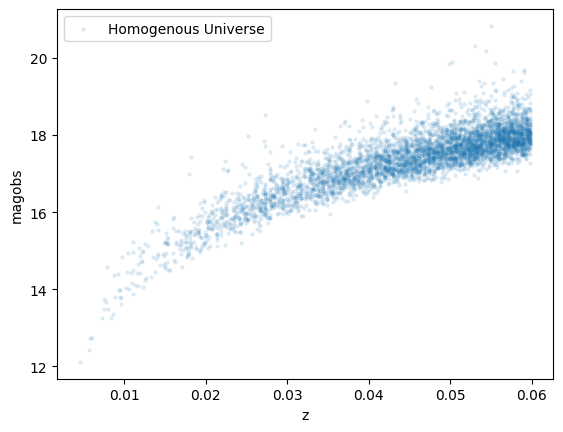

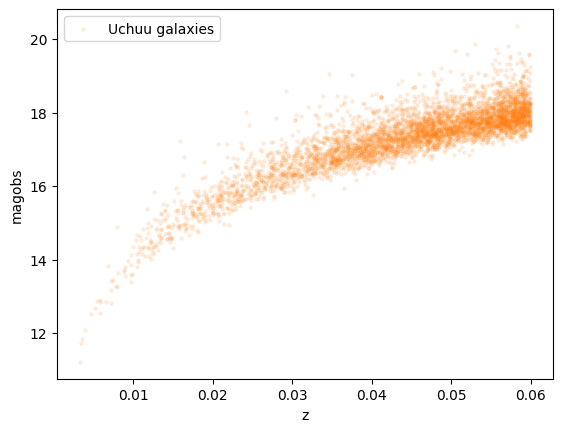

In [335]:
snia_default.data.plot.scatter('z','magobs', marker='.', alpha=0.1, color='tab:blue', label='Homogenous Universe')
# plt.savefig("../figures/homogeneous_magobs_z.png")
snia.data.plot.scatter('z','magobs', marker='.', alpha=0.1, color='tab:orange', label='Uchuu galaxies')
# plt.savefig("../figures/Uchuu_magobs_z.png")

In [336]:
from astropy.constants import c
from scipy.integrate import quad
from astropy.cosmology import Planck18 as cosmo
cosmo.Ogamma0 + cosmo.Onu0, cosmo.Om0, cosmo.Ode0, cosmo.H0.value

(0.0014936944554559178, 0.30966, 0.6888463055445441, 67.66)

In [337]:
def dist(z, Omega_r, Omega_m, Omega_l, H0):
    Omega_k = 1. - Omega_m - Omega_l - Omega_r
    return quad(lambda z1 : (Omega_m*(1+z1)**3 + Omega_r*(1+z1)**4 + Omega_k*(1+z1)**2 + Omega_l)**(-0.5)*c.value*10**(-3)/H0, 0, z)

dist_vec = np.vectorize(dist)

def f(z, Omega_m, Omega_r=cosmo.Ogamma0 + cosmo.Onu0, H0=cosmo.H0.value, Omega_l=cosmo.Ode0):
    return 5.0 * np.log10(abs((z + 1.0) * dist_vec(z, Omega_r, Omega_m, Omega_l, H0)[0])) + 25

In [338]:
from scipy.optimize import curve_fit

popt_uchuu, pcov_uchuu = curve_fit(f,
                       np.array(snia.data['z']),
                       np.array(snia.data['magobs'] - snia.data['magabs'].mean()),
                       p0=[cosmo.Om0],
                       bounds=([0.2],[0.4])
                      )

In [339]:
print("O_m = {}".format(*popt_uchuu))

O_m = 0.30586665084164766


In [340]:
popt_def, pcov_def = curve_fit(f,
                       np.array(snia_default.data['z']),
                       np.array(snia_default.data['magobs'] - snia_default.data['magabs'].mean()),
                       p0=[cosmo.Om0],
                       bounds=([0.2],[0.4])
                      )

In [341]:
print("\nO_m = {}".format(*popt_def))


O_m = 0.34324779430022223


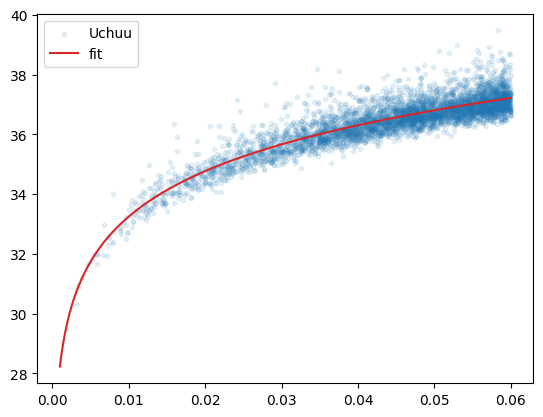

In [343]:
plt.scatter(snia.data['z'],np.array(snia.data['magobs'] - snia.data['magabs'].mean()), marker='.', alpha=0.1, color='tab:blue', label='Uchuu')

plt.plot(np.linspace(1e-3,0.06,1000), f(np.linspace(1e-3,0.06,1000),*popt_uchuu), label="fit", color='tab:red')
plt.legend()

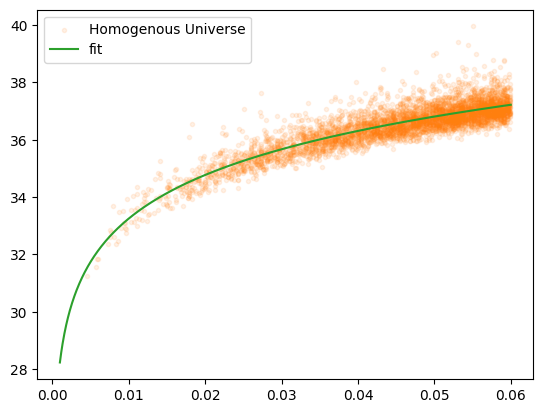

In [344]:
plt.scatter(snia_default.data['z'], snia_default.data['magobs'] - snia_default.data['magabs'].mean(), marker='.', alpha=0.1, color='tab:orange', label='Homogenous Universe')
plt.plot(np.linspace(1e-3,0.06,1000), f(np.linspace(1e-3,0.06,1000),*popt_def), label="fit", color='tab:green')
plt.legend()

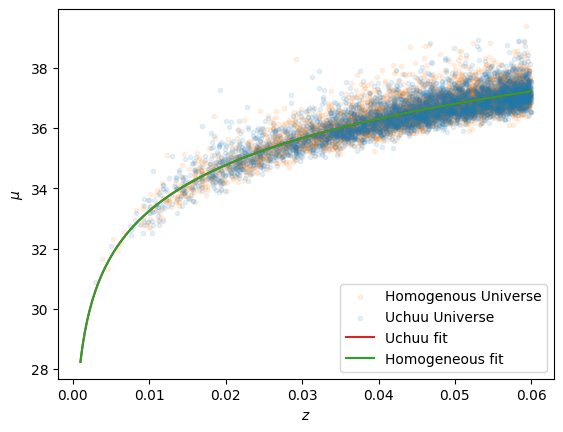

In [30]:
plt.scatter(snia_default.data['z'],np.array(snia_default.data['magobs'] - snia_default.data['magabs'].mean()), marker='.', alpha=0.1, color='tab:orange', label='Homogenous Universe')
plt.scatter(snia.data['z'],np.array(snia.data['magobs'] - snia.data['magabs'].mean()), marker='.', alpha=0.1, color='tab:blue', label='Uchuu Universe')

plt.plot(np.linspace(1e-3,0.06,1000), f(np.linspace(1e-3,0.06,1000),*popt_uchuu), color='tab:red', label="Uchuu fit")
plt.plot(np.linspace(1e-3,0.06,1000), f(np.linspace(1e-3,0.06,1000),*popt_def), color='tab:green', label="Homogeneous fit")
plt.ylabel("$\mu$")
plt.xlabel("$z$")

plt.legend()
# plt.savefig('../figures/Homogenous_vs_uchuu_mag.png')

### LC

In [64]:
snia = SNeIa_full_bgs()
_ = snia.draw(tstart=survey.date_range[0], tstop=survey.date_range[0], inplace=True,  zmax=0.06)

In [10]:
dset = skysurvey.DataSet.from_targets_and_survey(snia, survey)

/global/homes/a/agillesl/.local/perlmutter/python-3.11/lib/python3.11/site-packages/ztffields/projection.py:157: UserWarning: cannot use dask_geopandas with MultiIndex fields dataframe
  warnings.warn("cannot use dask_geopandas with MultiIndex fields dataframe")
100%|██████████| 7419/7419 [00:47<00:00, 155.78it/s]
/global/homes/a/agillesl/.local/perlmutter/python-3.11/lib/python3.11/site-packages/skysurvey/dataset.py:154: FutureWarning: The behavior of pd.concat with len(keys) != len(objs) is deprecated. In a future version this will raise instead of truncating to the smaller of the two sequences
  data = pandas.concat(lightcurves, keys=fieldids # store fieldid


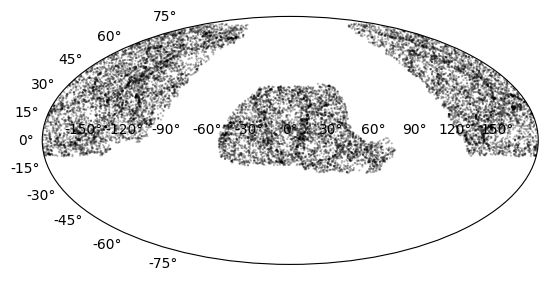

In [72]:
fig = plt.figure()
ax = fig.add_subplot(projection="mollweide")
mollweide_scatter(dset.targets.data, ax=ax,)


In [15]:
index = dset_sanitize_and_filter(dset)

100%|██████████| 4421/4421 [00:16<00:00, 271.43it/s]


In [6]:
with open("data/SN_Uchuu.pkl", 'rb') as f:
    lc = pickle.load(f)
    data = pickle.load(f)
    res_sn = pickle.load(f)
dset = skysurvey.DataSet(lc)
dset.set_survey(extract_ztf())
dset.set_targets(SNeIa_full_bgs.from_data(data))

In [9]:
len(index)

2463

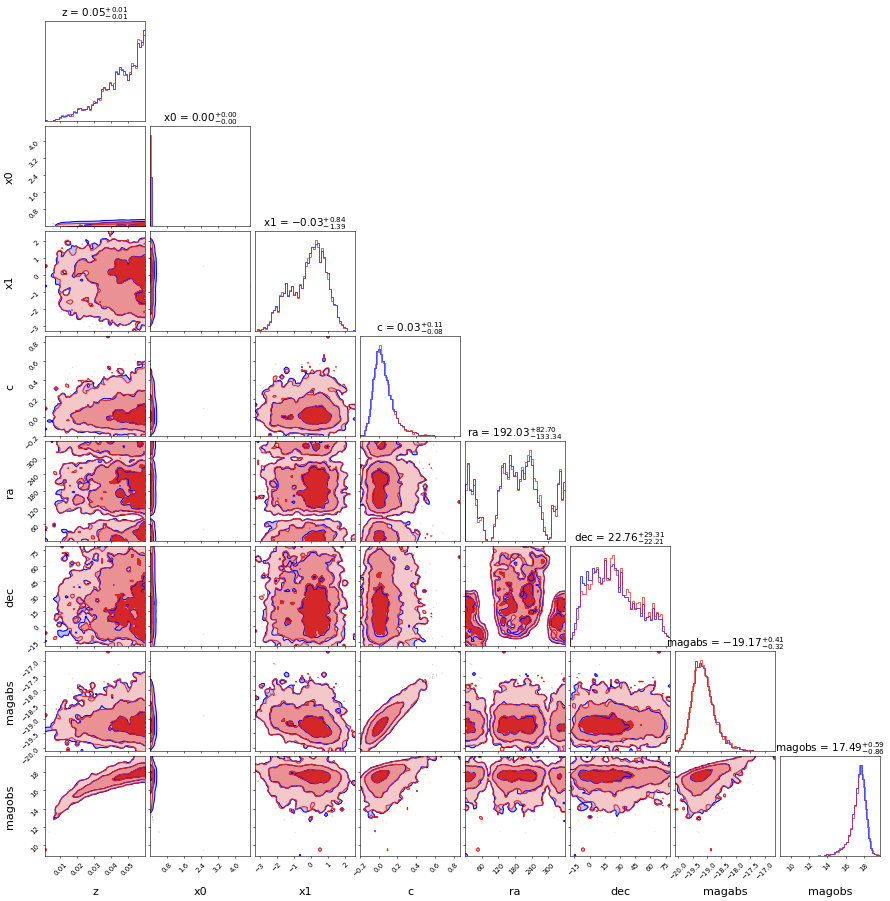

In [10]:
%matplotlib inline
fig = corner_(dset.targets.data,
    var_names=["z", "x0", "x1", "c", "ra", "dec", "magabs", "magobs"],
    labels=[
        r"$z$",
        r"$x_0$",
        r"$x_1$",
        r"$c$",
        r"RA",
        r"DEC",
        r"$M_{ABS}$",
        r"$M_{OBS}$",
    ])
_=corner_(dset.targets.data[dset.targets.data["keep"]],
    var_names=["z", "x0", "x1", "c", "ra", "dec", "magabs", "magobs"],
    fig = fig,
    color='tab:red')


Text(0.5, 1.0, 'Rate corrected')

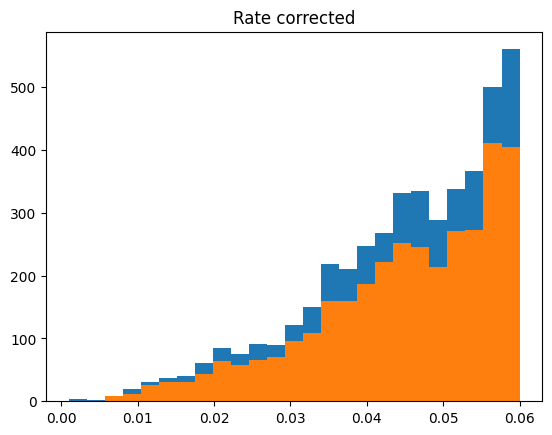

In [11]:
%matplotlib inline
_, bins,_ =plt.hist(dset.targets.data["z"], bins =25)
_ = plt.hist(dset.targets.data[dset.targets.data["keep"]]["z"], bins=bins)
plt.title('Rate corrected')

### Selection cut

In [12]:
np.sum(dset.targets.data['good'])

2743

/tmp/ipykernel_361613/2217368323.py:5: RuntimeWarning: invalid value encountered in divide
  plt.plot((bins[1:]+bins[:-1])/2, filtfilt([1/5]*5, 1, surv/full))


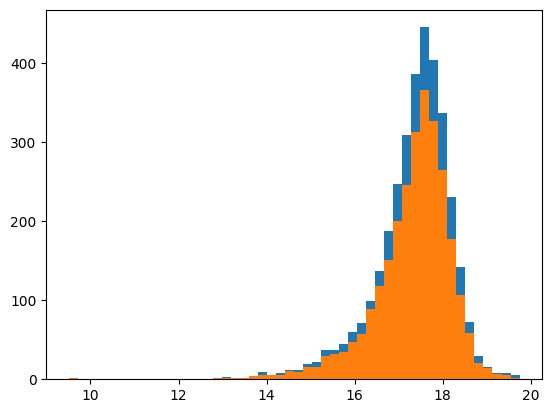

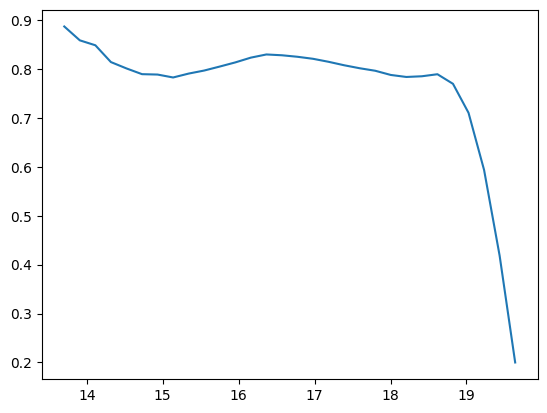

In [356]:
full, bins, _=plt.hist(dset.targets.data[dset.targets.data["keep"]]["magobs"], bins =50)
surv,_,_ = plt.hist(dset.targets.data[dset.targets.data["good"]]["magobs"], bins=bins)
plt.figure()
from scipy.signal import filtfilt
plt.plot((bins[1:]+bins[:-1])/2, filtfilt([1/5]*5, 1, surv/full))

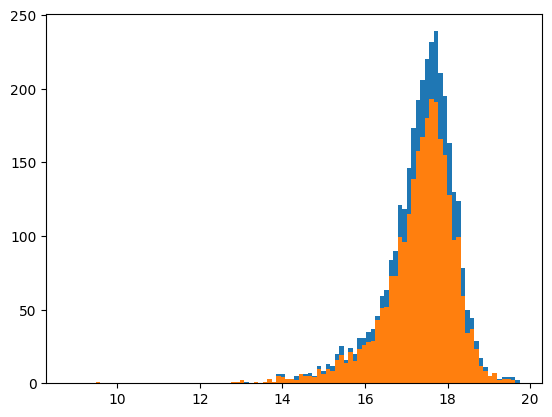

In [357]:
_,bins =np.histogram(dset.targets.data["magobs"], bins=100)
kept,_,_=plt.hist(dset.targets.data[dset.targets.data["keep"]]["magobs"], bins=bins)
good,_,_=plt.hist(dset.targets.data[dset.targets.data["good"]]["magobs"], bins=bins)

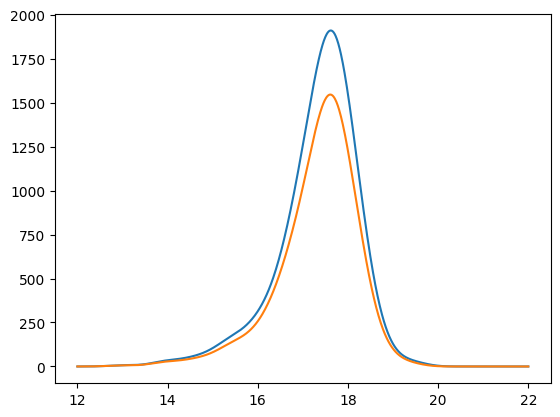

In [358]:
from scipy.stats import gaussian_kde
kept_kde = gaussian_kde(dset.targets.data[dset.targets.data["keep"]]["magobs"], bw_method=0.3)
good_kde = gaussian_kde(dset.targets.data[dset.targets.data["good"]]["magobs"], bw_method=0.3)

mag = np.linspace(12, 22, 1000)
plt.plot(mag, kept_kde(mag)*np.sum(dset.targets.data["keep"]))
plt.plot(mag, good_kde(mag)*np.sum(dset.targets.data["good"]))


In [359]:
mid = (bins[:-1] + bins[1:])/2
mid[kept > 0][[0,-1]]

array([ 9.532465, 19.689556], dtype=float32)

In [369]:
def sigmoid(x, alpha, beta, A=1):
    return A/(1 + np.exp(alpha*(x-beta)))

In [370]:
from scipy.optimize import curve_fit
popt, pcov = curve_fit(sigmoid, mag, good_kde(mag)*np.sum(dset.targets.data["good"])/(kept_kde(mag)*np.sum(dset.targets.data["keep"])), p0=[9.532465, 19.689556,1.])

In [371]:
popt

array([ 2.97668968, 19.96889684,  0.82943   ])

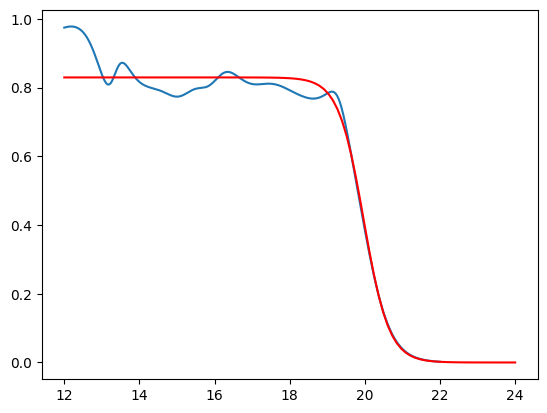

In [372]:
plt.plot(mag, good_kde(mag)*np.sum(dset.targets.data["good"])/(kept_kde(mag)*np.sum(dset.targets.data["keep"])))
plt.plot(np.linspace(12, 24, 100), sigmoid(np.linspace(12, 24, 100),*popt),'r')

### LC fit

In [21]:
with open("data/SN_Uchuu_modelcov.pkl", 'rb') as f:
    lc = pickle.load(f)
    data = pickle.load(f)
    res_sn = pickle.load(f)
    meta = pickle.load(f)
dset = skysurvey.DataSet(lc)
dset.set_survey(extract_ztf())
dset.set_targets(SNeIa_full_bgs.from_data(data))

In [23]:
index = dset_sanitize_and_filter(dset)

100%|██████████| 4419/4419 [00:17<00:00, 245.57it/s]


In [24]:
len(index)

2434

In [54]:
dset.targets.data.loc[277,"good"] = False

In [84]:
index = np.where(dset.targets.data["good"])[0]
len(index)

2432

In [31]:
def fit_lc(dset, index, savefile=None, **kwargs):
    fixed = {"z": dset.targets.data.loc[index]["z"]}

    guess = {
        "t0": dset.targets.data.loc[index]["t0"],
        "c": dset.targets.data.loc[index]["c"],
        "x0": dset.targets.data.loc[index]["x0"],
        "x1": dset.targets.data.loc[index]["x1"],
    }
    bounds = {
        "t0": dset.targets.data.loc[index]["t0"].apply(lambda x: [x - 20, x + 30]),
        "c": dset.targets.data.loc[index]["c"].apply(lambda x: [-0.8, 1.0]),
        "x0": dset.targets.data.loc[index]["x0"].apply(lambda x: [-0.9, 0.9]),
        "x1": dset.targets.data.loc[index]["x1"].apply(lambda x: [-6, 6]),
    }

    params = dict(phase_fitrange=[-40,130], maxcall=10000)
    params.update(kwargs)

    results, meta, models = dset.fit_lightcurves(
        source=sncosmo.Model("salt2"),
        index=index,
        use_dask=False,
        fixedparams=fixed,
        guessparams=guess,
        bounds=bounds,
        **params
    )

    if savefile:
        with open(savefile, "wb") as f:
            pickle.dump(dset.data, f)
            pickle.dump(dset.targets.data, f)
            pickle.dump(results, f)
            pickle.dump(meta, f)

    return results, meta, models


In [30]:
results, meta, models = fit_lc(dset,
                               index,
                               savefile='data/SN_Uchuu_modelcov.pkl',
                               modelcov=True)

ValueError: Expected a 1D array, got an array with shape (2434, 2)

In [91]:
# with open('data/SN_Uchuu_modelcov.pkl', "wb") as f:
#             pickle.dump(dset.data, f)
#             pickle.dump(dset.targets.data, f)
#             pickle.dump(results, f)
#             pickle.dump(meta, f)

In [85]:
success = [meta[(i,"success")] for i in index]

In [86]:
sum(success)

1938

In [87]:
dset.targets.data["converged"]=False

In [ ]:
meta.

SyntaxError: invalid syntax (920563946.py, line 1)

In [89]:
for i in index:
    dset.targets.data.loc[i,'converged'] = meta[(i,"success")]

In [68]:
with open("data/SN_Uchuu_modelcov.pkl", 'rb') as f:
    lc = pickle.load(f)
    data = pickle.load(f)
    res_sn = pickle.load(f)
    meta = pickle.load(f)
dset = skysurvey.DataSet(lc)
dset.set_survey(extract_ztf())
dset.set_targets(SNeIa_full_bgs.from_data(data))

In [164]:
index = data[data["converged"]].index

In [165]:
index

Index([   4,    5,    6,   10,   12,   13,   14,   15,   16,   18,
       ...
       4455, 4457, 4460, 4462, 4466, 4468, 4470, 4471, 4472, 4477],
      dtype='int64', length=1959)

In [166]:
better_results=pandas.DataFrame(
    {
        **{col: np.array(res_sn["value"].loc[map(lambda x: (x, col), index)])
        for col in ["t0", "c", "x0", "x1"]},
        **{"err_"+col: np.array(res_sn["error"].loc[map(lambda x: (x, col), index)]) for col in ["t0", "c", "x0", "x1"]},
        **{"delta_"+col : np.array(res_sn["value"].loc[map(lambda x: (x, col), index)]) - np.array(res_sn["truth"].loc[map(lambda x: (x, col), index)])
        for col in ["t0", "c", "x0", "x1"]},
    }, index = index
)

In [167]:
res_sn = res_sn.loc[index]

In [24]:
from astropy.time import Time

def plot_lc(dset, i, better_results=None, fig=None, **kwargs):
    _ = dset.show_target_lightcurve(index=i, s=8, fig=fig, **kwargs)
    plt.ylim(-200)
    target = dset.targets.data.loc[i]
    plt.axvline(Time(target["t0"], format="mjd").datetime, label=r'True $t_0$')
    if better_results:
        plt.axvline(Time(better_results.loc[i]["t0"], format="mjd").datetime, linestyle='--', c='darkblue', alpha=0.4, label = r'Fitted $t_0$')

        plt.axvline(Time(better_results.loc[i]["t0"] + better_results.loc[i]["err_t0"] , format="mjd").datetime, c='k', linestyle='dotted', label = r'$\sigma_{t_0}$')
        plt.axvline(Time(better_results.loc[i]["t0"] - better_results.loc[i]["err_t0"] , format="mjd").datetime, c='k', linestyle='dotted')

    
    plt.xlim(Time(target["t0"]-50, format="mjd").datetime, Time(target["t0"] +100, format="mjd").datetime)
    plt.legend()
    plt.title(f"Target {i}")


In [171]:
goods = (better_results['err_c'] < jnp.sqrt(0.07)) & \
        (abs(better_results['c']) < 0.3) & \
        (abs(better_results['x1']) + better_results['x1'] < 5)

/tmp/ipykernel_1190110/3370857107.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _=corner_(better_results[data[data['good']]['converged'] & goods])
/global/homes/a/agillesl/.local/perlmutter/python-3.11/lib/python3.11/site-packages/numpy/core/_methods.py:45: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/global/homes/a/agillesl/.local/perlmutter/python-3.11/lib/python3.11/site-packages/numpy/core/_methods.py:41: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


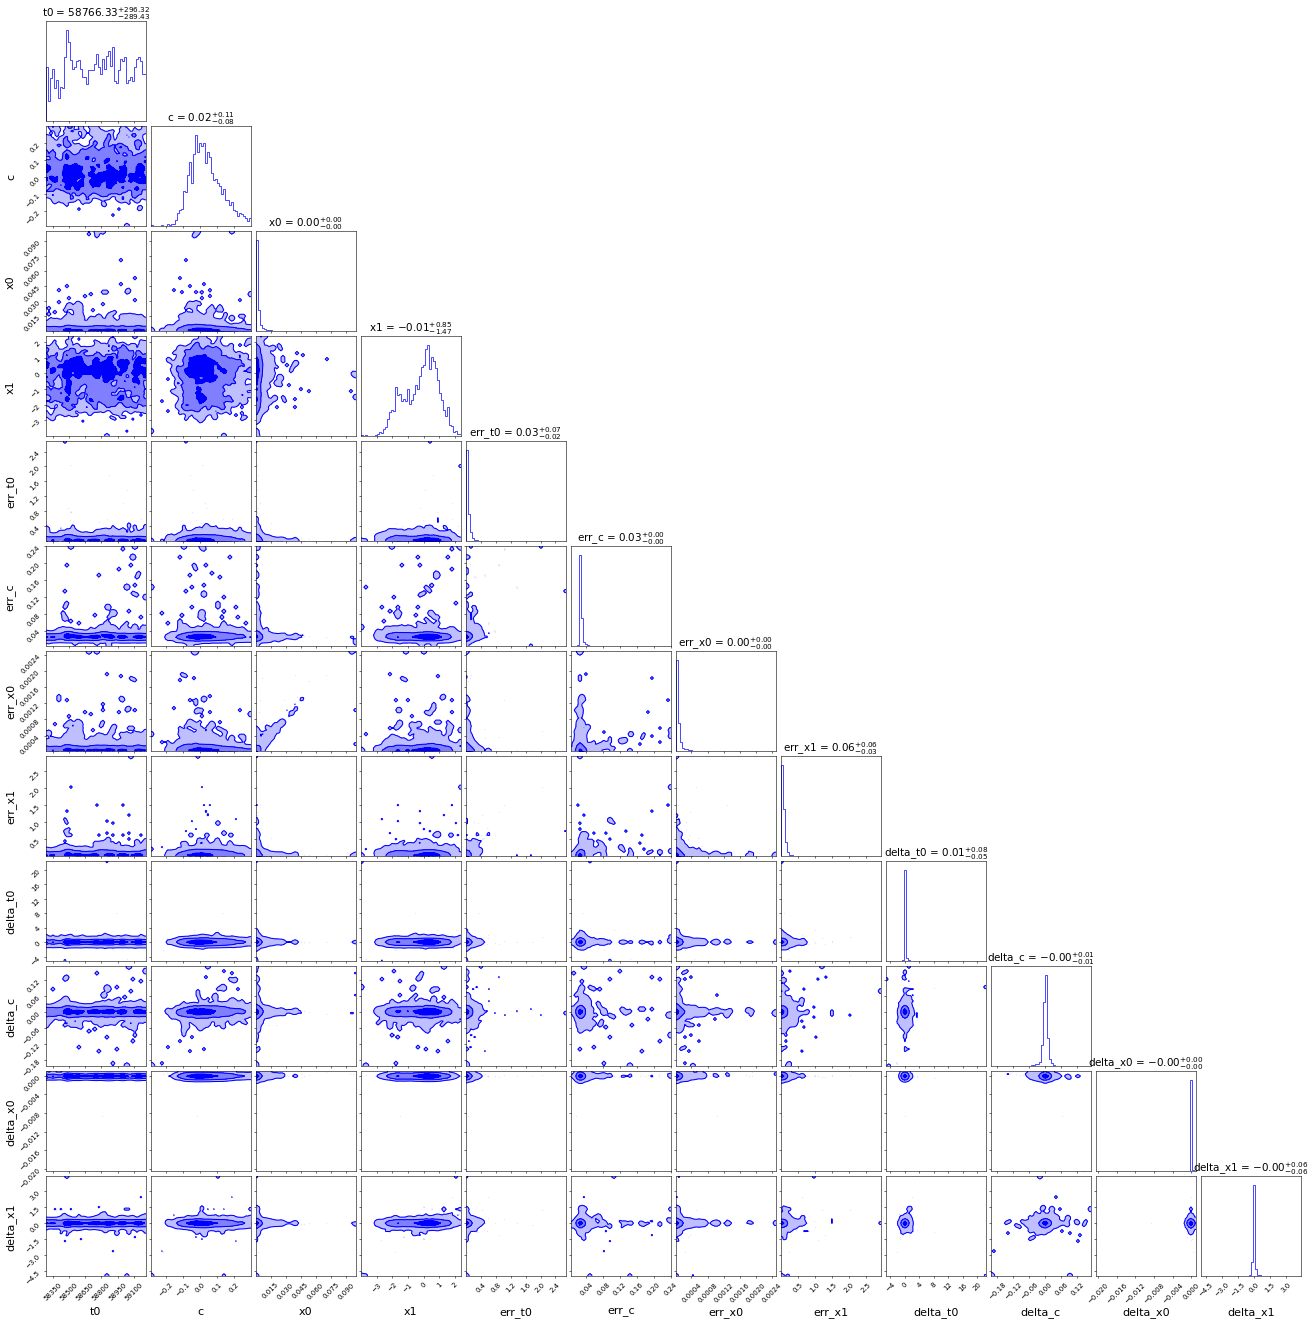

In [176]:
_=corner_(better_results[data[data['good']]['converged'] & goods])

In [136]:
def dset_from_res(better_results):
    data_r = data.join(better_results[['x1','c','t0','x0']], lsuffix = '_true').loc[index].copy()
    data_r = data_r[dset.targets.get_template_columns()].copy()
    dset_r = skysurvey.DataSet(data = lc.loc[index])
    dset_r.set_survey(extract_ztf())
    dset_r.set_targets(SNeIa_full_bgs.from_data(data_r))
    return dset_r

In [137]:
dset_r = dset_from_res(better_results)

In [47]:
with open("data/SN_Uchuu.pkl", 'rb') as f:
    lc_ = pickle.load(f)
    data_ = pickle.load(f)
    res_sn_ = pickle.load(f)

index = data_[data_["good"]].index[:800]
better_results_old=pandas.DataFrame(
    {
        **{col: np.array(res_sn_["value"].loc[map(lambda x: (x, col), index)])
        for col in ["t0", "c", "x0", "x1"]},
        **{"err_"+col: np.array(res_sn_["error"].loc[map(lambda x: (x, col), index)]) for col in ["t0", "c", "x0", "x1"]},
        **{"delta_"+col : np.array(res_sn_["value"].loc[map(lambda x: (x, col), index)]) - np.array(res_sn_["truth"].loc[map(lambda x: (x, col), index)])
        for col in ["t0", "c", "x0", "x1"]},
    }, index = index
)

dset_old_fit=dset_from_res(better_results_old)

In [138]:
def plot_lc_reconstruct(dset_r, index, fig=None,**kwargs):
    params = dict(colors=['red','green','yellow'], linestyle='dashed', linewidth=1,
                                time_range=[-20,50], npoints=500,
                                zp=25, zpsys="ab",
                                format_time=True, t0_format="mjd", 
                                in_mag=False, invert_mag=True, label='fit')
    params.update(kwargs)
    _=dset_r.targets.get_target_template(index).show_lightcurve(['ztfr', 'ztfg', 'ztfi'], params={},
                                ax=plt.gca(), **params
                                )
    plt.legend()

# ZTF position in Uchuu

In [3]:
bgs_df = load_bgs(columns=['RA', 'DEC', 'Z', 'Z_COSMO', 'STATUS', 'V_PEAK', 'V_RMS','R_MAG_ABS','R_MAG_APP'])

Found file ../../project/Projet-LPNHE/data/Uchuu.csv with columns Index(['r_mag_app', 'r_mag_abs', 'dec', 'ra', 'z_cosmo', 'z', 'v_peak',
       'v_rms', 'in_desi'],
      dtype='object')


In [ ]:
ztf_sn = pandas.read_csv('data/data_ztf.csv', index_col=0)
ztf_sn

In [44]:
snia = SNeIa_full_bgs()
data = snia.draw(size=5000, inplace=True,  zmax=0.06)


In [ ]:
_=corner_(ztf_sn[ztf_sn['valid']==1],
        var_names=['ra','dec','z','tmax', 'x0', 'x1', 'c'])

In [45]:
%matplotlib inline

In [46]:
survey = extract_ztf()

ztf_sn = ztf_sn[ztf_sn['tmax'].between(survey.date_range[0], survey.date_range[1])].copy()
ztf_sn
nside = 128

In [48]:
ids = healpy.ang2pix(theta = np.pi/2 - ztf_sn['dec']*np.pi/180, phi=ztf_sn['ra']*np.pi/180, nside=nside)
map_ = np.zeros(healpy.nside2npix(nside))
for i in tqdm(ids):
    map_[i] += 1
map_ = healpy.smoothing(map_, fwhm=0.1)
map_ -= map_.min()
id_bgs = healpy.ang2pix(theta = np.pi/2 - bgs_df['dec']*np.pi/180, phi=bgs_df['ra']*np.pi/180, nside=nside)
mask = np.zeros(healpy.nside2npix(nside), dtype=bool)
for i in tqdm(id_bgs):
    mask[i] = True
#map_[~mask]=0
map_ /= np.sum(map_)

z_nside = 64
id_bgs = healpy.ang2pix(theta = np.pi/2 - bgs_df['dec']*np.pi/180, phi=bgs_df['ra']*np.pi/180, nside=z_nside)
bgs_pix = [[]]*healpy.nside2npix(z_nside)
for i,nb_pix in tqdm(enumerate(id_bgs), total = len(id_bgs)):
    bgs_pix[nb_pix] = bgs_pix[nb_pix] + [id_bgs.index[i]]

bgs_pix = [np.array(bgs_df.loc[ids]['z']) for ids in bgs_pix]

  0%|          | 0/3170 [00:00<?, ?it/s]

  0%|          | 0/4698044 [00:00<?, ?it/s]

  0%|          | 0/4698044 [00:00<?, ?it/s]

In [ ]:
healpy.mollview(map_)

In [ ]:
spl = np.random.choice(np.arange(healpy.nside2npix(nside)), size=100000, p=map_)
map_sampled = np.zeros(healpy.nside2npix(nside))
for i in tqdm(spl):
    map_sampled[i] += 1
map_sampled = healpy.smoothing(map_sampled, fwhm=0.02)

healpy.mollview(map_sampled)

In [51]:
healpy.ang2pix(z_nside, *healpy.pix2ang(nside, spl))

array([19180,  6003, 16408, ...,   468, 23826,  7955])

In [52]:
np.where([len(l)>0 for l in bgs_pix])[0]

array([  385,   386,   389, ..., 32684, 32685, 32937])

In [53]:
def rand_ztf_positions(maps, size=1, zcut=0.1):
    ztf_map, bgs_redshifts = maps
    ztf_nside = healpy.npix2nside(len(ztf_map))
    bgs_nside = healpy.npix2nside(len(bgs_nside))
    
    sampled_pix = np.random.choice(np.arange(healpy.nside2npix(nside)), size=size, p=ztf_map)
    
    bgs_sampled_pix = healpy.ang2pix(bgs_nside, *healpy.pix2ang(ztf_nside, spl))
    
    for angpix, zpix in zip(sampled_pix,bgs_sampled_pix):
        new_ra, new_dec = draw_from_pixel(angpix, ztf_nside)
        ra.append(new_ra)
        dec.append(new_dec)

        kde = gaussian_kde(bgs_redshifts[zpix])
        z.append(kde.resample(1)[0][0])

    return(ra, dec, z)

def draw_from_pixel(pix, nside):
    boundaries_theta,boundaries_ra = healpy.vec2ang(healpy.boundaries(nside, pix).T)
    boundaries_dec = np.pi/2 - boundaries_theta
    boundaries_ra = boundaries_ra[(boundaries_dec != -np.pi/2) & (boundaries_dec != np.pi/2)]

    min_, max_ = np.min(boundaries_ra), np.max(boundaries_ra)
    if max_-min_>= 2*np.pi-np.pi/nside:
        boundaries_ra[boundaries_ra < np.pi]+= 2*np.pi
    min_, max_ = np.min(boundaries_ra),np.max(boundaries_ra)

    in_pix = False
    while not in_pix:
        draw_ra = np.random.uniform(min_, max_)
        draw_ra -= 2*np.pi*(draw_ra > 2*np.pi)
        draw_dec = np.arcsin(np.random.uniform(np.min(np.sin(boundaries_dec)), np.max(np.sin(boundaries_dec))))
        in_pix = (pix == healpy.ang2pix(nside, 0.5 * np.pi - draw_dec, draw_ra))
    
    return np.array([draw_ra, draw_dec])


In [54]:
with open("data/bgs_redshifts_map.pkl", "wb") as fp:
    pickle.dump(bgs_pix, fp)

55


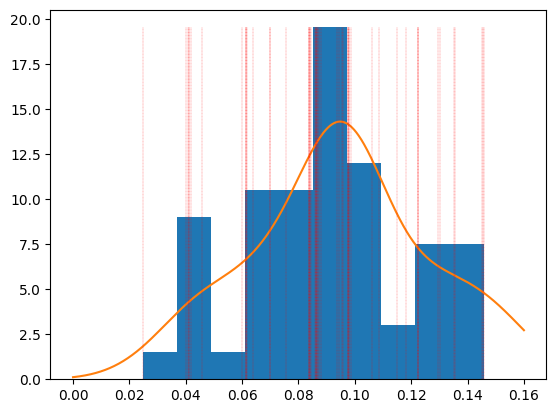

In [72]:
from scipy.stats import gaussian_kde
pix = 32684
print(len(bgs_pix[pix]))
if len(bgs_pix[pix]) > 0:
    h,_,_=plt.hist(bgs_pix[pix], density=True)
    kde = gaussian_kde(bgs_pix[pix])
    _=plt.plot(np.linspace(0, 0.16, 1000), kde.pdf(np.linspace(0, 0.15, 1000)))
    _=plt.vlines(bgs_pix[pix], 0,np.max(h), color='r', linestyle='--', linewidth=0.2)

In [ ]:
map_bgs = np.zeros(healpy.nside2npix(64))
for i in tqdm(id_bgs):
    map_bgs[i] += 1
map_bgs = healpy.smoothing(map_bgs, fwhm=0.1)
healpy.mollview(map_bgs)

In [ ]:
start = time.time()
dset = skysurvey.DataSet.from_targets_and_survey(snia, survey)
stop = time.time()
time.strftime('%H:%M:%S', time.gmtime(stop - start))

In [ ]:
det = dset.get_ndetection(detlimit=7) > 10
detected = det[det].index
len(detected)

In [ ]:
def detection_av_ap(dset, detected):
    n_det = []
    dset.data["detected"] = (dset.data["flux"]/dset.data["fluxerr"]) > 5
    for i in tqdm(detected):
        target = dset.targets.data.loc[i]
        obs_data = dset.data[dset.data["detected"]].loc[i]
        n_det.append((np.sum(obs_data["time"].between(target["t0"] - 50, target["t0"])), np.sum(obs_data["time"].between(target["t0"], target["t0"]+200))))
    return detected[~np.any(np.array(n_det) < 3, axis=1)]
        
id_det = detection_av_ap(dset, detected)

In [ ]:
def fit_lc(dset, id_det):
    fixed = {"z": dset.targets.data.loc[id_det]["z"]}

    guess = {
        "t0": dset.targets.data.loc[id_det]["t0"],
        "c": dset.targets.data.loc[id_det]["c"],
        "x0": dset.targets.data.loc[id_det]["x0"],
        "x1": dset.targets.data.loc[id_det]["x1"],
    }
    bounds = {
        "t0": dset.targets.data.loc[id_det]["t0"].apply(lambda x: [x-5, x+5]),
        "c": dset.targets.data.loc[id_det]["c"].apply(lambda x: [-0.3, 1.0]),
        "x0": dset.targets.data.loc[id_det]["x0"].apply(lambda x: [-0.1, 0.1]),
        "x1": dset.targets.data.loc[id_det]["x1"].apply(lambda x: [-4, 4]),
    }

    results, meta = dset.fit_lightcurves(
        source=sncosmo.Model("salt2"),
        index=id_det,
        use_dask=False,
        fixedparams=fixed,
        guessparams=guess,
        bounds=bounds,
    )

    better_results = pandas.DataFrame(
        {
            **{col: np.array(results["value"].loc[map(lambda x: (x, col), id_det[:400])] - \
                          results["truth"].loc[map(lambda x: (x, col), id_det[:400])])
            for col in guess.keys()},
            **{"err_"+col: np.array(results["error"].loc[map(lambda x: (x, col), id_det[:400])]) for col in guess.keys()}
        }
    )
    return better_results

In [ ]:
results_ztf = fit_lc(dset, id_det[:400])

In [ ]:
fig=corner_(results_ztf,
    fig=plt.figure(figsize=(20,20)),
    var_names=list(guess.keys()),
    color='tab:blue')

In [ ]:
snia_bgs = SNeIa_full_bgs()

In [ ]:
snia_bgs.draw(tstart=survey.date_range[0], tstop=survey.date_range[1], zmax=0.06, inplace=True)
dset_bgs = skysurvey.DataSet.from_targets_and_survey(snia_bgs, survey)

In [ ]:
det = dset_bgs.get_ndetection(detlimit=7) > 10
detected_bgs = det[det].index
id_det_bgs = detection_av_ap(dset_bgs, detected_bgs)

In [ ]:
_=plt.hist(snia_bgs.data['redshift'], bins=50, histtype='step', density=True)
_=plt.hist(snia_bgs.data['z'], bins=50, histtype='step', density=True)
_=plt.hist(snia.data['z'], bins=50, histtype='step', density=True)

In [ ]:
fig =corner_(snia_bgs.data, ['ra','dec','z'], fig=plt.figure(figsize=(15,15)), color='tab:blue', bins=30)
_=corner_(snia.data, ['ra','dec','z'], fig=fig, color='tab:red', bins=30)


In [ ]:
fig =corner_(snia_bgs.data.loc[id_det_bgs], ['ra','dec','z'], fig=plt.figure(figsize=(15,15)), color='tab:blue', bins=30)
_=corner_(snia.data.loc[id_det], ['ra','dec','z'], fig=fig, color='tab:red', bins=30)


In [ ]:
results_bgs = fit_lc(dset_bgs, id_det_bgs[:400])

In [ ]:
fig=corner_(results_bgs,
    fig=plt.figure(figsize=(20,20)),
    var_names=list(guess.keys()),
    color='tab:red')

_=corner_(better_results,
    fig=fig,
    var_names=list(guess.keys()),
    color='tab:blue')


# EDRIS

### Run

In [7]:
with open("data/SN_Uchuu_modelcov.pkl", 'rb') as f:
    lc = pickle.load(f)
    data = pickle.load(f)
    res_sn = pickle.load(f)
    meta = pickle.load(f)

In [20]:
data["c"].apply(lambda x: [-0.8, 1.0]),

(0       [-0.8, 1.0]
 1       [-0.8, 1.0]
 2       [-0.8, 1.0]
 3       [-0.8, 1.0]
 4       [-0.8, 1.0]
            ...     
 4473    [-0.8, 1.0]
 4474    [-0.8, 1.0]
 4475    [-0.8, 1.0]
 4476    [-0.8, 1.0]
 4477    [-0.8, 1.0]
 Name: c, Length: 4478, dtype: object,)

In [93]:
index = data[data['converged']].index
index

Index([   4,    5,    6,   10,   12,   13,   14,   15,   16,   18,
       ...
       4454, 4455, 4457, 4460, 4462, 4466, 4468, 4471, 4472, 4477],
      dtype='int64', length=1938)

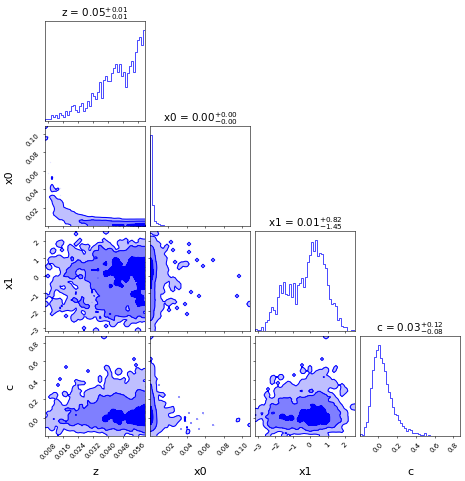

In [94]:
_=corner_(data.loc[index],var_names=["z","x0","x1","c"])

In [95]:
# %lprun -f sncosmo_to_edris
exp, cov, obs = sncosmo_to_edris(res_sn, data, index, n_bins=6)

/global/homes/a/agillesl/.local/perlmutter/python-3.11/lib/python3.11/site-packages/jax/_src/lax/lax.py:516: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)


Text(0.5, 1.0, 'Redshift bins')

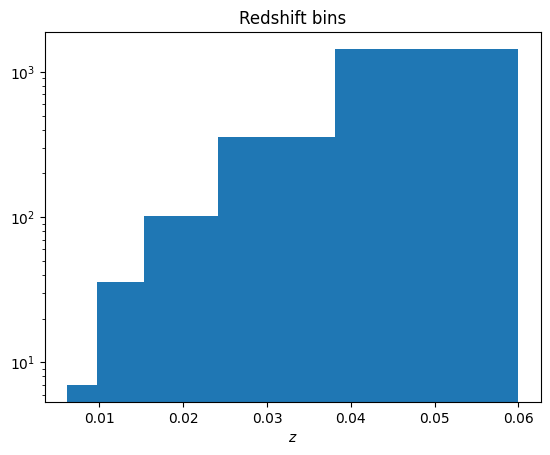

In [96]:
plt.hist(exp["z"], bins=exp["z_bins"], log=True)
plt.xlabel('$z$')
plt.title('Redshift bins')
# plt.savefig(f'../figures/edris_{n}sn_zdist.png')

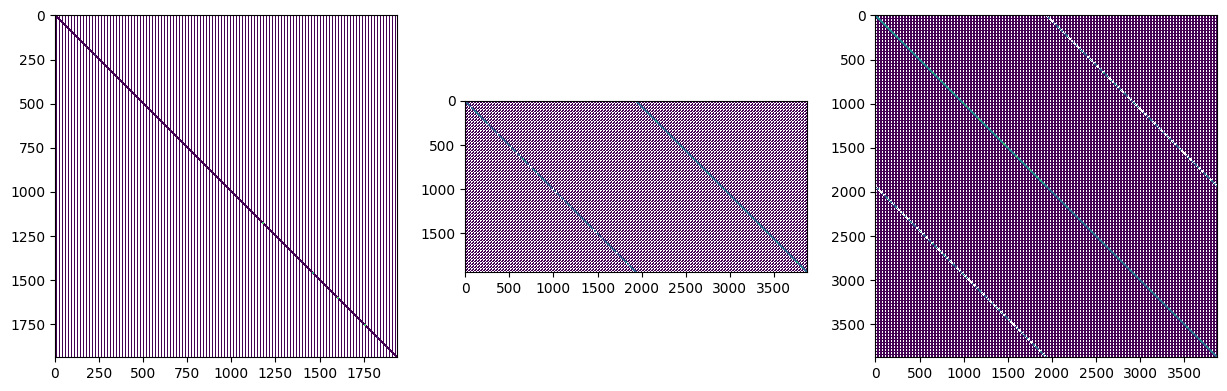

In [97]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15,5))
ax1.imshow(cov.C_mm, norm='log')
ax2.imshow(cov.C_mx, norm='log')
ax3.imshow(cov.C_xx, norm='log')


In [98]:
n = len(index)

In [99]:
goods = (jnp.sqrt(jnp.diag(cov.C_xx[n:,n:])) < 0.07) & (abs(obs.variables[n:]) < 0.3) & (jnp.sqrt(jnp.diag(cov.C_xx[:n,:n])) + jnp.abs(obs.variables[:n]) < 5)
exp['z'] = exp['z'][goods]
obs.mag = obs.mag[goods]
obs.variables = obs.variables[jnp.tile(goods, 2)]
cov_sel = cov.select(goods)

/global/homes/a/agillesl/.local/perlmutter/python-3.11/lib/python3.11/site-packages/jax/_src/lax/lax.py:516: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)


In [ ]:
fig, axs = plt.subplots(nrows = 3, ncols=3, figsize=(15,15))
axs[0,0].hist(jnp.diag(cov_sel.C_mm), log=True)
axs[0,0].set_xlabel(r'$Cov_{MM}$')
axs[0,1].hist(jnp.diag(cov_sel.C_mx[:,:n]), log=True)
axs[0,1].set_xlabel(r'$Cov_{MX_1}$')
axs[0,2].hist(jnp.diag(cov_sel.C_mx[:,n:]), log=True)
axs[0,2].set_xlabel(r'$Cov_{MC}$')
axs[1,1].hist(jnp.diag(cov_sel.C_xx[:n,:n]), log=True)
axs[1,1].set_xlabel(r'$Cov_{X_1X_1}$')
axs[1,2].hist(jnp.diag(cov_sel.C_xx[:n,n:]), log=True)
axs[1,2].set_xlabel(r'$Cov_{X_1C}$')
axs[2,2].hist(jnp.diag(cov_sel.C_xx[n:,n:]), log=True)
axs[2,2].set_xlabel(r'$Cov_{CC}$')

In [101]:
x0 = {
      'mu_bins':jnp.zeros(len(exp['z_bins'])),
      'coef':jnp.array([-0.14,3.15]),
      'variables':jnp.array(obs.variables.reshape((2,-1 ))),
     }
# Apply a first standardization guess
delta_mu = obs.mag - edris.models.sn1a_model(x0, exp).mag
interpol_matrix = edris.tools.linear_interpolation_matrix(jnp.log10(exp['z']), jnp.log10(exp['z_bins']))
mu_start = jnp.linalg.solve(jnp.dot(interpol_matrix.T, interpol_matrix), jnp.dot(interpol_matrix.T, delta_mu))
x0['mu_bins'] = mu_start

In [102]:
data['used_edris'] = False
data.loc[data.loc[index[np.where(goods)]].index,'used_edris'] = True

In [103]:
L = lambda x: edris.tools.restrict(edris.models.likelihood, {'sigma_int':0.1,})(
    x, exp, cov_sel, obs, cosmo=edris.cosmo.binned_cosmo, truncated=False, restricted=False
)

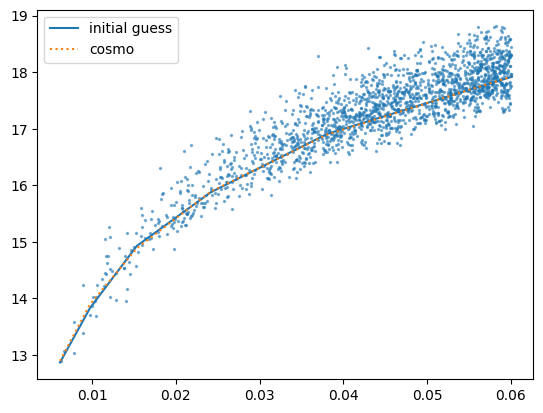

In [104]:
%matplotlib inline
from astropy.cosmology import Planck18 as cosmo
plt.scatter(exp["z"], obs.mag, s=2, alpha=0.5)
plt.plot(exp["z_bins"], x0['mu_bins'], label='initial guess')
plt.plot(exp["z_bins"],  jnp.array(cosmo.distmod(np.array(exp['z_bins']))) -19.3, label='cosmo', linestyle=':')
plt.legend()
# plt.savefig(f'../figures/init_edris_mag_{n}_SN.png')

In [189]:
# fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15,5))
# ax1.imshow(cov_sel.C_mm, norm='log')
# ax2.imshow(cov_sel.C_mx, norm='log')
# ax3.imshow(cov_sel.C_xx, norm='log')
# plt.savefig(f'../figures/init_edris_cov_{n}_SN.png')

In [105]:
res, loss, lmbda, iter_params = edris.minimize.tncg(L, x0, 1000, lmbda=1e4, tol=1e-2,
                                    verbose=True, max_iter_tncg=None,
                                    )

iter 0/1000. Loss: -6.3e+03->-6.6e+03(-2.2e+02), ρ=0.85, λ=3000.0
iter 1/1000. Loss: -6.6e+03->-6.8e+03(-2.1e+02), ρ=0.74, λ=3000.0
iter 2/1000. Loss: -6.8e+03->-6.8e+03(-53), ρ=0.76, λ=900.0
iter 3/1000. Loss: -6.8e+03->-6.9e+03(-25), ρ=0.69, λ=900.0
iter 4/1000. Loss: -6.9e+03->-6.9e+03(-5.7), ρ=0.82, λ=270.0
iter 5/1000. Loss: -6.9e+03->-6.9e+03(-6.1), ρ=0.81, λ=81.0
iter 6/1000. Loss: -6.9e+03->-6.9e+03(-4.9), ρ=0.75, λ=81.0
iter 7/1000. Loss: -6.9e+03->-6.9e+03(-1.6), ρ=0.83, λ=24.3
iter 8/1000. Loss: -6.9e+03->-6.9e+03(-1.6), ρ=0.79, λ=7.29
iter 9/1000. Loss: -6.9e+03->-6.9e+03(-0.91), ρ=0.69, λ=7.29
iter 10/1000. Loss: -6.9e+03->-6.9e+03(-0.14), ρ=0.70, λ=7.29
iter 11/1000. Loss: -6.9e+03->-6.9e+03(-0.024), ρ=0.71, λ=7.29
iter 12/1000. Loss: -6.9e+03->-6.9e+03(-0.0042), ρ=0.71, λ=7.29
converged in 12 iterations
Completed in 58.72s


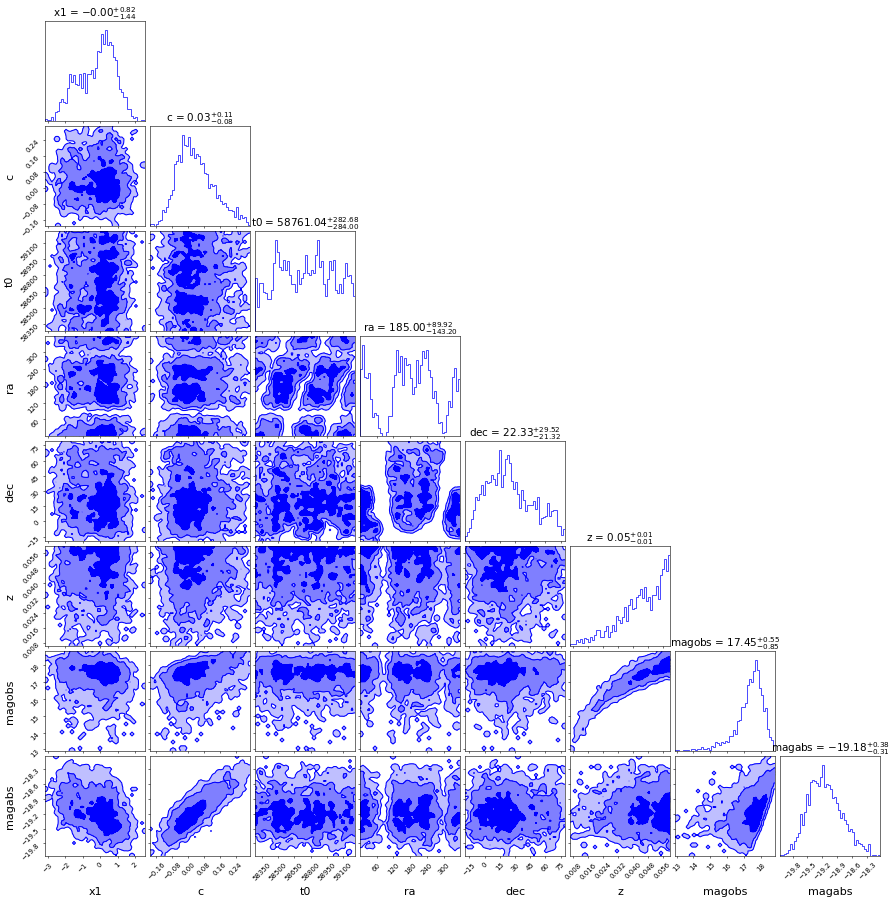

In [108]:
_=corner_(data[data['used_edris']], var_names=['x1','c','t0','ra','dec','z','magobs','magabs'])


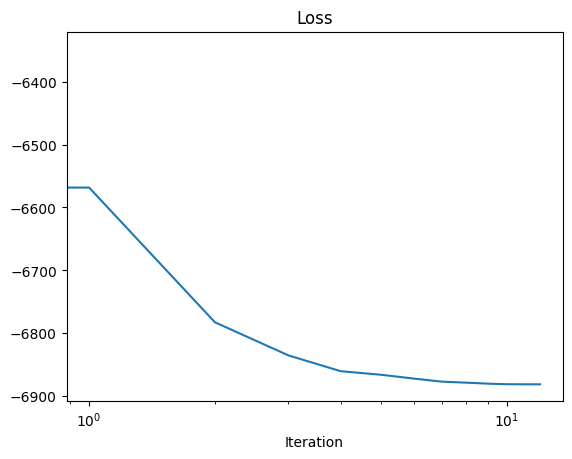

In [109]:
%matplotlib inline
plt.figure()
plt.plot(loss)
plt.title("Loss")
plt.xlabel('Iteration')
plt.xscale('log')
# plt.savefig(f'../figures/edris_loss_{n}_SN.png')

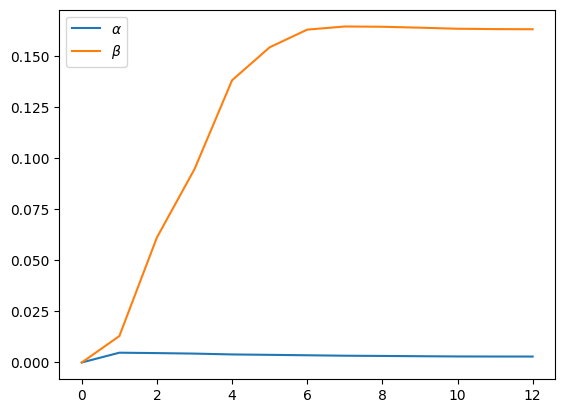

In [110]:
%matplotlib inline
plt.plot(jnp.array([param["coef"]-jnp.array([-0.14,3.15]) for param in iter_params]), label=[r"$\alpha$",r"$\beta$"])
plt.legend()
plt.show()

In [117]:
hess = jax.hessian(L)(res)

n_var = len(hess['coef']['coef'])
n_bins = len(hess['mu_bins']['mu_bins'])
n = hess['variables']['variables'].shape[1]
row1 = jnp.hstack((hess['coef']['coef'], hess['coef']['mu_bins'], hess['coef']['variables'].reshape(n_var, n*n_var)))
row2 = jnp.hstack((hess['mu_bins']['coef'], hess['mu_bins']['mu_bins'], hess['mu_bins']['variables'].reshape(n_bins,n*n_var)))
row3 = jnp.hstack((hess['variables']['coef'].reshape(n*n_var,n_var),
                   hess['variables']['mu_bins'].reshape(n*n_var,n_bins),
                   hess['variables']['variables'].reshape(n*n_var,n*n_var)))
flatten_hessian = jnp.vstack((row1, row2, row3))

cov_res =  jnp.linalg.inv(0.5 * flatten_hessian)

n, n_var, n_bins

sigma_inv = jnp.diag(1/jnp.sqrt(jnp.diag(cov_res)))
corr = jnp.matmul(sigma_inv,jnp.matmul(cov_res, sigma_inv))

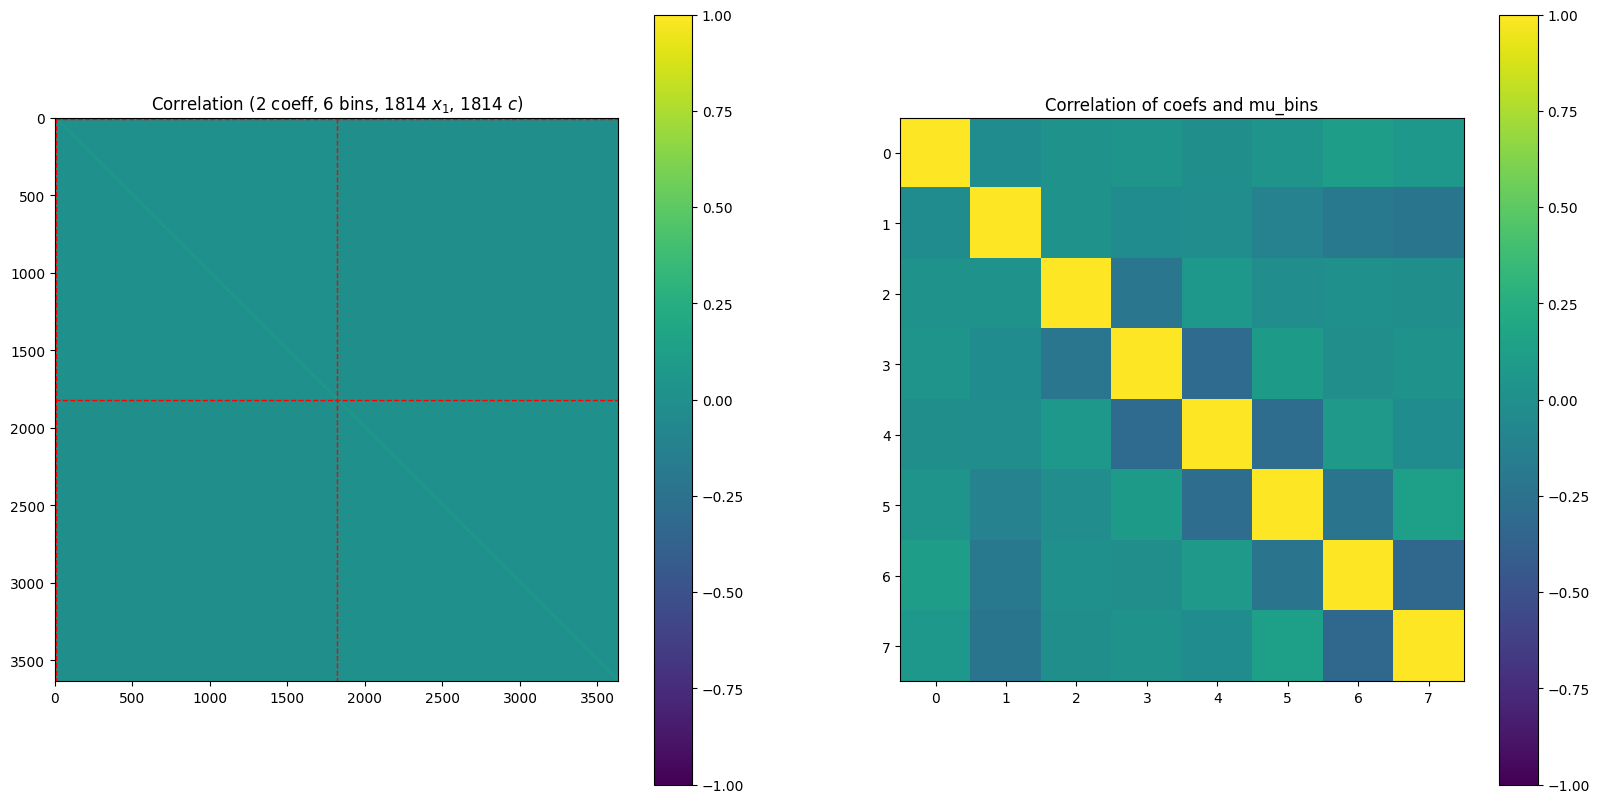

In [118]:
from matplotlib import colors
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20,10))
im1 = ax1.imshow(corr, norm = colors.Normalize(vmin=-1.0, vmax=1.0))
ax1.set_title(f'Correlation (2 coeff, {n_bins} bins, {n} $x_1$, {n} $c$)')
ax1.hlines([n_var+n_bins-.5, n+n_var+n_bins-.5], xmin=0, xmax=n_var*n+n_var+n_bins-.5, linestyle='--', linewidth=1, color='r')
ax1.vlines([n_var+n_bins-.5, n+n_var+n_bins-.5], ymin=0, ymax=n_var*n+n_var+n_bins-.5, linestyle='--', linewidth=1, color='r')
cb = ax2.figure.colorbar(im1, ax=ax1)

im2 = ax2.imshow(corr[:n_bins+2,:n_bins+2], norm = colors.Normalize(vmin=-1.0, vmax=1.0))
ax2.set_title('Correlation of coefs and mu_bins')
ax2.figure.colorbar(im2, ax=ax2)


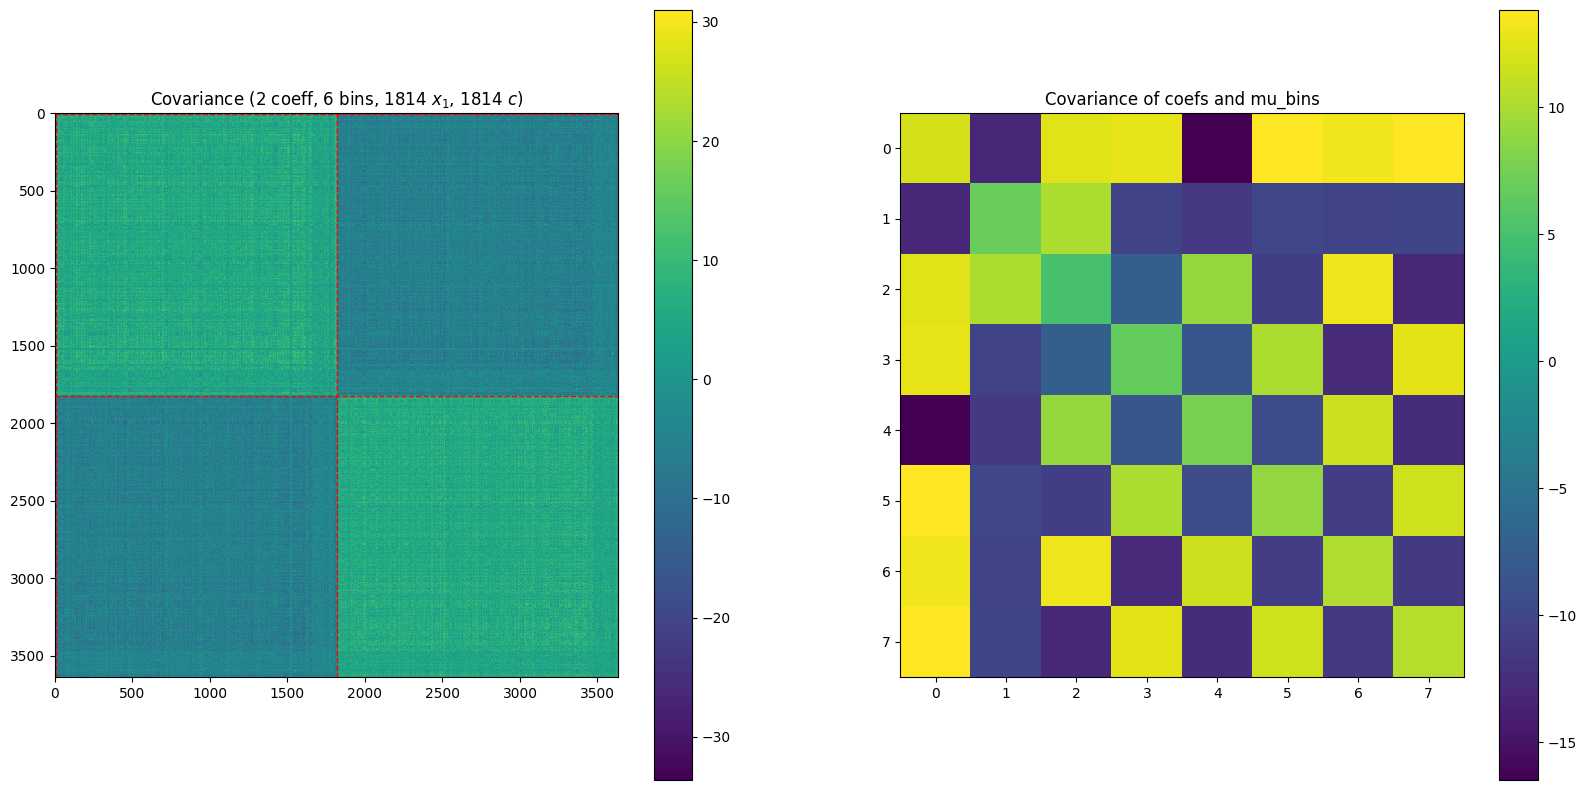

In [128]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20,10))
im1 = ax1.imshow(-jnp.sign(cov_res)*jnp.log(jnp.abs(cov_res)))
ax1.set_title(f'Covariance ({n_var} coeff, {n_bins} bins, {n} $x_1$, {n} $c$)')
ax1.hlines([n_var+n_bins-.5, n+n_var+n_bins-.5], xmin=0, xmax=n_var*n+n_var+n_bins-.5, linestyle='--', linewidth=1, color='r')
ax1.vlines([n_var+n_bins-.5, n+n_var+n_bins-.5], ymin=0, ymax=n_var*n+n_var+n_bins-.5, linestyle='--', linewidth=1, color='r')

im2 = ax2.imshow((-jnp.sign(cov_res)*jnp.log(jnp.abs(cov_res)))[:n_bins+2,:n_bins+2])
ax2.set_title('Covariance of coefs and mu_bins')

ax2.figure.colorbar(im1, ax=ax1)
ax2.figure.colorbar(im2, ax=ax2)
plt.savefig(f'../figures/edris_test_cov.png')

In [120]:
from astropy.cosmology import Planck18 as cosmo
params = {'mu_bins': jnp.array(cosmo.distmod(np.array(exp['z_bins'])))- 19.3,
         'coef': jnp.array([-0.14, 3.15]),
         'variables': jnp.array([obs.variables.copy()]),
         # 'M0':10.501611
         }

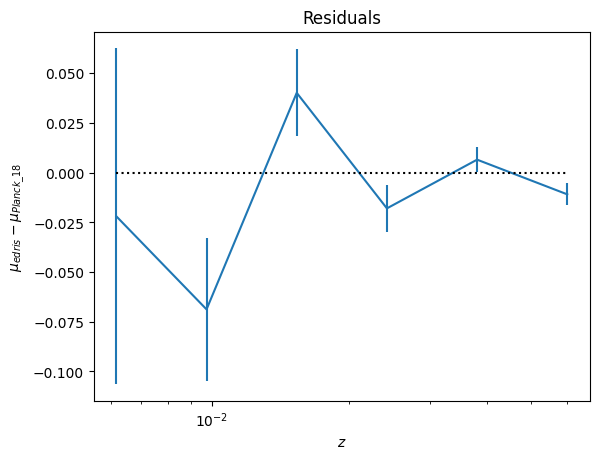

In [130]:
plt.figure('residuals')
plt.errorbar(exp['z_bins'], res['mu_bins'] - params['mu_bins'], yerr=jnp.sqrt(jnp.diag(cov_res[2:2+n_bins,2:2+n_bins])))
plt.errorbar(exp['z_bins'], np.zeros_like(exp["z_bins"]), linestyle=':', color='k')
plt.title('Residuals')
plt.xlabel("$z$")
plt.ylabel("$\mu_{edris} - \mu_{Planck\_18}$")
plt.xscale('log')
plt.savefig(f'../figures/edris_test_residuals.png')

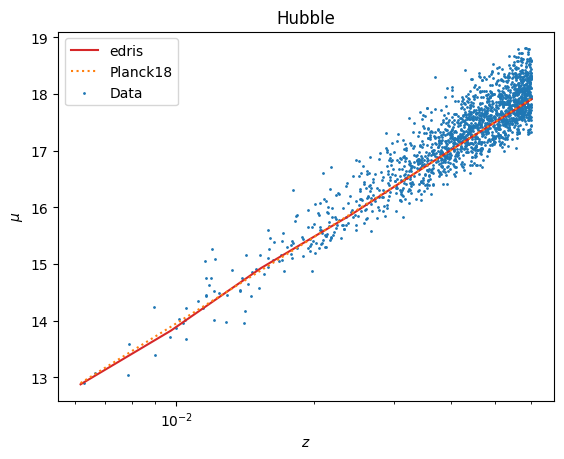

In [126]:
plt.plot(exp['z_bins'], res['mu_bins'], color='tab:red', label='edris')
plt.plot(exp['z_bins'], params['mu_bins'], color='tab:orange', linestyle=':', label='Planck18')
plt.scatter(exp['z'], obs.mag, s=1, label='Data')
plt.xscale("log")
plt.title('Hubble')
plt.xlabel("$z$")
plt.ylabel("$\mu$")
plt.legend()
plt.savefig(f'../figures/edris_test_Hubble.png')

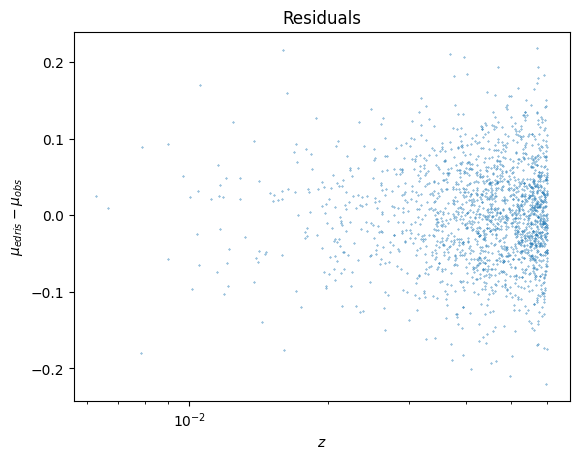

In [124]:
plt.figure('residuals')
plt.scatter(exp['z'], obs.mag-edris.models.sn1a_model(res, exp).mag, s=.1)
plt.title('Residuals')
plt.xlabel("$z$")
plt.ylabel("$\mu_{edris} - \mu_{obs}$")
# plt.savefig(f'../figures/edris_{n}sn_bias.png')
plt.xscale('log')

In [125]:
with open("data/SN_Uchuu_edris_res.pkl", 'wb') as f:
    pickle.dump(exp, f)
    pickle.dump(obs, f)
    pickle.dump(cov, f)
    pickle.dump(res, f)
    pickle.dump(cov_res, f)
    pickle.dump(iter_params, f)

In [389]:
better_results=pandas.DataFrame(
    {
        **{col: np.array(res_sn["value"].loc[map(lambda x: (x, col), index)])
        for col in ["t0", "c", "x0", "x1"]},
        **{"err_"+col: np.array(res_sn["error"].loc[map(lambda x: (x, col), index)]) for col in ["t0", "c", "x0", "x1"]},
        **{"delta_"+col : np.array(res_sn["value"].loc[map(lambda x: (x, col), index)]) - np.array(res_sn["truth"].loc[map(lambda x: (x, col), index)])
        for col in ["t0", "c", "x0", "x1"]},
    }, index = index
)


### Bin number ?

In [ ]:
from tqdm.auto import tqdm

In [221]:
n_b = [2,3,4,5,6,7,8,9,10]
n = len(index)

In [232]:
z_bins = [edris.tools.log_bins(data.loc[index]["z"].min() - 1e-4, 0.06, n_bins) for n_bins in n_b]

In [224]:
results=[]
covs=[]

for n_bins in tqdm(n_b):
    exp, cov, obs = sncosmo_to_edris(res_sn, data, index[goods], n_bins=n_bins)
    x0 = {
          'mu_bins':jnp.zeros(len(exp['z_bins'])),
          'coef':jnp.array([-0.14,3.15]),
          'variables':jnp.array(obs.variables.reshape((2,-1 ))),
         }
    # Apply a first standardization guess
    delta_mu = obs.mag - edris.models.sn1a_model(x0, exp).mag
    interpol_matrix = edris.tools.linear_interpolation_matrix(jnp.log10(exp['z']), jnp.log10(exp['z_bins']))
    mu_start = jnp.linalg.solve(jnp.dot(interpol_matrix.T, interpol_matrix), jnp.dot(interpol_matrix.T, delta_mu))
    x0['mu_bins'] = mu_start
    L = lambda x: edris.tools.restrict(edris.models.likelihood, {'sigma_int':0.1,})(
        x, exp, cov_sel, obs, cosmo=edris.cosmo.binned_cosmo, truncated=False, restricted=False
    )
    res, loss, lmbda, iter_params = edris.minimize.tncg(L, x0, 1000, lmbda=1e4, tol=1e-2,
                                    verbose=True, max_iter_tncg=None,
                                    )
    hess = jax.hessian(L)(res)
    n_var = len(hess['coef']['coef'])
    n_bins = len(hess['mu_bins']['mu_bins'])
    n = hess['variables']['variables'].shape[1]
    row1 = jnp.hstack((hess['coef']['coef'], hess['coef']['mu_bins'], hess['coef']['variables'].reshape(n_var, n*n_var)))
    row2 = jnp.hstack((hess['mu_bins']['coef'], hess['mu_bins']['mu_bins'], hess['mu_bins']['variables'].reshape(n_bins,n*n_var)))
    row3 = jnp.hstack((hess['variables']['coef'].reshape(n*n_var,n_var),
                       hess['variables']['mu_bins'].reshape(n*n_var,n_bins),
                       hess['variables']['variables'].reshape(n*n_var,n*n_var)))
    flatten_hessian = jnp.vstack((row1, row2, row3))
    cov_res =  jnp.linalg.inv(0.5 * flatten_hessian)
    covs.append(cov_res)
    results.append(res)

  0%|          | 0/9 [00:00<?, ?it/s]

/global/homes/a/agillesl/.local/perlmutter/python-3.11/lib/python3.11/site-packages/jax/_src/lax/lax.py:516: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)


iter 0/1000. Loss: -6.3e+03->-6.5e+03(-2.2e+02), ρ=0.87, λ=3000.0
iter 1/1000. Loss: -6.5e+03->-6.7e+03(-2.1e+02), ρ=0.74, λ=3000.0
iter 2/1000. Loss: -6.7e+03->-6.8e+03(-52), ρ=0.76, λ=900.0
iter 3/1000. Loss: -6.8e+03->-6.8e+03(-24), ρ=0.69, λ=900.0
iter 4/1000. Loss: -6.8e+03->-6.8e+03(-5.3), ρ=0.81, λ=270.0
iter 5/1000. Loss: -6.8e+03->-6.8e+03(-5.4), ρ=0.80, λ=81.0
iter 6/1000. Loss: -6.8e+03->-6.8e+03(-4.5), ρ=0.77, λ=24.3
iter 7/1000. Loss: -6.8e+03->-6.8e+03(-3.4), ρ=0.78, λ=7.29
iter 8/1000. Loss: -6.8e+03->-6.8e+03(-2.6), ρ=0.75, λ=2.187
iter 9/1000. Loss: -6.8e+03->-6.8e+03(-1), ρ=0.65, λ=2.187
iter 10/1000. Loss: -6.8e+03->-6.8e+03(-0.1), ρ=0.68, λ=2.187
iter 11/1000. Loss: -6.8e+03->-6.8e+03(-0.015), ρ=0.71, λ=2.187
iter 12/1000. Loss: -6.8e+03->-6.8e+03(-0.0027), ρ=0.73, λ=2.187
converged in 12 iterations
Completed in 94.90s


/global/homes/a/agillesl/.local/perlmutter/python-3.11/lib/python3.11/site-packages/jax/_src/lax/lax.py:516: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)


iter 0/1000. Loss: -6.3e+03->-6.5e+03(-2.2e+02), ρ=0.87, λ=3000.0
iter 1/1000. Loss: -6.5e+03->-6.7e+03(-2.1e+02), ρ=0.74, λ=3000.0
iter 2/1000. Loss: -6.7e+03->-6.8e+03(-52), ρ=0.76, λ=900.0
iter 3/1000. Loss: -6.8e+03->-6.8e+03(-25), ρ=0.69, λ=900.0
iter 4/1000. Loss: -6.8e+03->-6.8e+03(-5.4), ρ=0.81, λ=270.0
iter 5/1000. Loss: -6.8e+03->-6.8e+03(-5.4), ρ=0.80, λ=81.0
iter 6/1000. Loss: -6.8e+03->-6.8e+03(-4.6), ρ=0.77, λ=24.3
iter 7/1000. Loss: -6.8e+03->-6.8e+03(-3.4), ρ=0.78, λ=7.29
iter 8/1000. Loss: -6.8e+03->-6.8e+03(-2.6), ρ=0.75, λ=2.187
iter 9/1000. Loss: -6.8e+03->-6.8e+03(-1), ρ=0.65, λ=2.187
iter 10/1000. Loss: -6.8e+03->-6.8e+03(-0.1), ρ=0.67, λ=2.187
iter 11/1000. Loss: -6.8e+03->-6.8e+03(-0.014), ρ=0.70, λ=2.187
iter 12/1000. Loss: -6.8e+03->-6.8e+03(-0.0026), ρ=0.73, λ=2.187
converged in 12 iterations
Completed in 95.40s


/global/homes/a/agillesl/.local/perlmutter/python-3.11/lib/python3.11/site-packages/jax/_src/lax/lax.py:516: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)


iter 0/1000. Loss: -6.3e+03->-6.5e+03(-2.2e+02), ρ=0.87, λ=3000.0
iter 1/1000. Loss: -6.5e+03->-6.7e+03(-2.1e+02), ρ=0.74, λ=3000.0
iter 2/1000. Loss: -6.7e+03->-6.8e+03(-52), ρ=0.76, λ=900.0
iter 3/1000. Loss: -6.8e+03->-6.8e+03(-25), ρ=0.69, λ=900.0
iter 4/1000. Loss: -6.8e+03->-6.8e+03(-5.4), ρ=0.81, λ=270.0
iter 5/1000. Loss: -6.8e+03->-6.8e+03(-5.4), ρ=0.80, λ=81.0
iter 6/1000. Loss: -6.8e+03->-6.8e+03(-4.5), ρ=0.77, λ=24.3
iter 7/1000. Loss: -6.8e+03->-6.8e+03(-3.4), ρ=0.78, λ=7.29
iter 8/1000. Loss: -6.8e+03->-6.8e+03(-2.6), ρ=0.75, λ=2.187
iter 9/1000. Loss: -6.8e+03->-6.8e+03(-1), ρ=0.65, λ=2.187
iter 10/1000. Loss: -6.8e+03->-6.8e+03(-0.11), ρ=0.68, λ=2.187
iter 11/1000. Loss: -6.8e+03->-6.8e+03(-0.015), ρ=0.71, λ=2.187
iter 12/1000. Loss: -6.8e+03->-6.8e+03(-0.0028), ρ=0.73, λ=2.187
converged in 12 iterations
Completed in 94.51s


/global/homes/a/agillesl/.local/perlmutter/python-3.11/lib/python3.11/site-packages/jax/_src/lax/lax.py:516: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)


iter 0/1000. Loss: -6.3e+03->-6.5e+03(-2.2e+02), ρ=0.87, λ=3000.0
iter 1/1000. Loss: -6.5e+03->-6.7e+03(-2.1e+02), ρ=0.74, λ=3000.0
iter 2/1000. Loss: -6.7e+03->-6.8e+03(-52), ρ=0.76, λ=900.0
iter 3/1000. Loss: -6.8e+03->-6.8e+03(-25), ρ=0.69, λ=900.0
iter 4/1000. Loss: -6.8e+03->-6.8e+03(-5.4), ρ=0.81, λ=270.0
iter 5/1000. Loss: -6.8e+03->-6.8e+03(-5.4), ρ=0.80, λ=81.0
iter 6/1000. Loss: -6.8e+03->-6.8e+03(-4.6), ρ=0.77, λ=24.3
iter 7/1000. Loss: -6.8e+03->-6.8e+03(-3.4), ρ=0.78, λ=7.29
iter 8/1000. Loss: -6.8e+03->-6.8e+03(-2.7), ρ=0.76, λ=2.187
iter 9/1000. Loss: -6.8e+03->-6.8e+03(-1.1), ρ=0.65, λ=2.187
iter 10/1000. Loss: -6.8e+03->-6.8e+03(-0.11), ρ=0.68, λ=2.187
iter 11/1000. Loss: -6.8e+03->-6.8e+03(-0.015), ρ=0.71, λ=2.187
iter 12/1000. Loss: -6.8e+03->-6.8e+03(-0.0028), ρ=0.73, λ=2.187
converged in 12 iterations
Completed in 96.31s


/global/homes/a/agillesl/.local/perlmutter/python-3.11/lib/python3.11/site-packages/jax/_src/lax/lax.py:516: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)


iter 0/1000. Loss: -6.3e+03->-6.5e+03(-2.2e+02), ρ=0.87, λ=3000.0
iter 1/1000. Loss: -6.5e+03->-6.7e+03(-2.1e+02), ρ=0.74, λ=3000.0
iter 2/1000. Loss: -6.7e+03->-6.8e+03(-52), ρ=0.76, λ=900.0
iter 3/1000. Loss: -6.8e+03->-6.8e+03(-25), ρ=0.69, λ=900.0
iter 4/1000. Loss: -6.8e+03->-6.8e+03(-5.4), ρ=0.81, λ=270.0
iter 5/1000. Loss: -6.8e+03->-6.8e+03(-5.4), ρ=0.80, λ=81.0
iter 6/1000. Loss: -6.8e+03->-6.8e+03(-4.5), ρ=0.77, λ=24.3
iter 7/1000. Loss: -6.8e+03->-6.8e+03(-3.3), ρ=0.78, λ=7.29
iter 8/1000. Loss: -6.8e+03->-6.8e+03(-2.6), ρ=0.75, λ=2.187
iter 9/1000. Loss: -6.8e+03->-6.8e+03(-1), ρ=0.65, λ=2.187
iter 10/1000. Loss: -6.8e+03->-6.8e+03(-0.1), ρ=0.68, λ=2.187
iter 11/1000. Loss: -6.8e+03->-6.8e+03(-0.015), ρ=0.71, λ=2.187
iter 12/1000. Loss: -6.8e+03->-6.8e+03(-0.0027), ρ=0.73, λ=2.187
converged in 12 iterations
Completed in 108.10s


/global/homes/a/agillesl/.local/perlmutter/python-3.11/lib/python3.11/site-packages/jax/_src/lax/lax.py:516: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)


iter 0/1000. Loss: -6.3e+03->-6.5e+03(-2.2e+02), ρ=0.87, λ=3000.0
iter 1/1000. Loss: -6.5e+03->-6.7e+03(-2.1e+02), ρ=0.74, λ=3000.0
iter 2/1000. Loss: -6.7e+03->-6.8e+03(-52), ρ=0.76, λ=900.0
iter 3/1000. Loss: -6.8e+03->-6.8e+03(-25), ρ=0.69, λ=900.0
iter 4/1000. Loss: -6.8e+03->-6.8e+03(-5.4), ρ=0.81, λ=270.0
iter 5/1000. Loss: -6.8e+03->-6.8e+03(-5.4), ρ=0.80, λ=81.0
iter 6/1000. Loss: -6.8e+03->-6.8e+03(-4.5), ρ=0.77, λ=24.3
iter 7/1000. Loss: -6.8e+03->-6.8e+03(-3.3), ρ=0.78, λ=7.29
iter 8/1000. Loss: -6.8e+03->-6.8e+03(-2.6), ρ=0.75, λ=2.187
iter 9/1000. Loss: -6.8e+03->-6.8e+03(-1), ρ=0.65, λ=2.187
iter 10/1000. Loss: -6.8e+03->-6.8e+03(-0.1), ρ=0.68, λ=2.187
iter 11/1000. Loss: -6.8e+03->-6.8e+03(-0.015), ρ=0.71, λ=2.187
iter 12/1000. Loss: -6.8e+03->-6.8e+03(-0.0027), ρ=0.73, λ=2.187
converged in 12 iterations
Completed in 95.51s


/global/homes/a/agillesl/.local/perlmutter/python-3.11/lib/python3.11/site-packages/jax/_src/lax/lax.py:516: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)


iter 0/1000. Loss: -6.3e+03->-6.5e+03(-2.2e+02), ρ=0.87, λ=3000.0
iter 1/1000. Loss: -6.5e+03->-6.7e+03(-2.1e+02), ρ=0.74, λ=3000.0
iter 2/1000. Loss: -6.7e+03->-6.8e+03(-52), ρ=0.76, λ=900.0
iter 3/1000. Loss: -6.8e+03->-6.8e+03(-25), ρ=0.69, λ=900.0
iter 4/1000. Loss: -6.8e+03->-6.8e+03(-5.4), ρ=0.81, λ=270.0
iter 5/1000. Loss: -6.8e+03->-6.8e+03(-5.4), ρ=0.80, λ=81.0
iter 6/1000. Loss: -6.8e+03->-6.8e+03(-4.6), ρ=0.77, λ=24.3
iter 7/1000. Loss: -6.8e+03->-6.8e+03(-3.3), ρ=0.78, λ=7.29
iter 8/1000. Loss: -6.8e+03->-6.8e+03(-2.6), ρ=0.75, λ=2.187
iter 9/1000. Loss: -6.8e+03->-6.8e+03(-1), ρ=0.65, λ=2.187
iter 10/1000. Loss: -6.8e+03->-6.8e+03(-0.1), ρ=0.68, λ=2.187
iter 11/1000. Loss: -6.8e+03->-6.8e+03(-0.015), ρ=0.71, λ=2.187
iter 12/1000. Loss: -6.8e+03->-6.8e+03(-0.0027), ρ=0.73, λ=2.187
converged in 12 iterations
Completed in 95.11s


/global/homes/a/agillesl/.local/perlmutter/python-3.11/lib/python3.11/site-packages/jax/_src/lax/lax.py:516: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)


iter 0/1000. Loss: -6.3e+03->-6.5e+03(-2.2e+02), ρ=0.87, λ=3000.0
iter 1/1000. Loss: -6.5e+03->-6.7e+03(-2.1e+02), ρ=0.74, λ=3000.0
iter 2/1000. Loss: -6.7e+03->-6.8e+03(-52), ρ=0.76, λ=900.0
iter 3/1000. Loss: -6.8e+03->-6.8e+03(-25), ρ=0.69, λ=900.0
iter 4/1000. Loss: -6.8e+03->-6.8e+03(-5.4), ρ=0.81, λ=270.0
iter 5/1000. Loss: -6.8e+03->-6.8e+03(-5.4), ρ=0.80, λ=81.0
iter 6/1000. Loss: -6.8e+03->-6.8e+03(-4.5), ρ=0.77, λ=24.3
iter 7/1000. Loss: -6.8e+03->-6.8e+03(-3.3), ρ=0.78, λ=7.29
iter 8/1000. Loss: -6.8e+03->-6.8e+03(-2.6), ρ=0.75, λ=2.187
iter 9/1000. Loss: -6.8e+03->-6.8e+03(-1), ρ=0.65, λ=2.187
iter 10/1000. Loss: -6.8e+03->-6.8e+03(-0.1), ρ=0.68, λ=2.187
iter 11/1000. Loss: -6.8e+03->-6.8e+03(-0.015), ρ=0.71, λ=2.187
iter 12/1000. Loss: -6.8e+03->-6.8e+03(-0.0027), ρ=0.73, λ=2.187
converged in 12 iterations
Completed in 97.57s


/global/homes/a/agillesl/.local/perlmutter/python-3.11/lib/python3.11/site-packages/jax/_src/lax/lax.py:516: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)


iter 0/1000. Loss: -6.3e+03->-6.5e+03(-2.2e+02), ρ=0.87, λ=3000.0
iter 1/1000. Loss: -6.5e+03->-6.7e+03(-2.1e+02), ρ=0.74, λ=3000.0
iter 2/1000. Loss: -6.7e+03->-6.8e+03(-52), ρ=0.76, λ=900.0
iter 3/1000. Loss: -6.8e+03->-6.8e+03(-25), ρ=0.69, λ=900.0
iter 4/1000. Loss: -6.8e+03->-6.8e+03(-5.4), ρ=0.81, λ=270.0
iter 5/1000. Loss: -6.8e+03->-6.8e+03(-5.5), ρ=0.80, λ=81.0
iter 6/1000. Loss: -6.8e+03->-6.8e+03(-4.5), ρ=0.77, λ=24.3
iter 7/1000. Loss: -6.8e+03->-6.8e+03(-3.3), ρ=0.78, λ=7.29
iter 8/1000. Loss: -6.8e+03->-6.8e+03(-2.6), ρ=0.75, λ=2.187
iter 9/1000. Loss: -6.8e+03->-6.8e+03(-1), ρ=0.65, λ=2.187
iter 10/1000. Loss: -6.8e+03->-6.8e+03(-0.1), ρ=0.68, λ=2.187
iter 11/1000. Loss: -6.8e+03->-6.8e+03(-0.014), ρ=0.71, λ=2.187
iter 12/1000. Loss: -6.8e+03->-6.8e+03(-0.0027), ρ=0.73, λ=2.187
converged in 12 iterations
Completed in 96.87s


In [ ]:
n_var=2
for img, n_bins in zip(covs,n_b):
    fig, ax2 = plt.subplots(figsize=(7,7))
    sigma_inv = jnp.diag(1/jnp.sqrt(jnp.diag(img)))
    corr = jnp.matmul(sigma_inv,jnp.matmul(img, sigma_inv))

    im2 = ax2.imshow(corr[:n_bins+2,:n_bins+2], norm = colors.Normalize(vmin=-1.0, vmax=1.0))
    ax2.set_title('Correlation of coefs and mu_bins')
    ax2.figure.colorbar(im2, ax=ax2)

    plt.show()


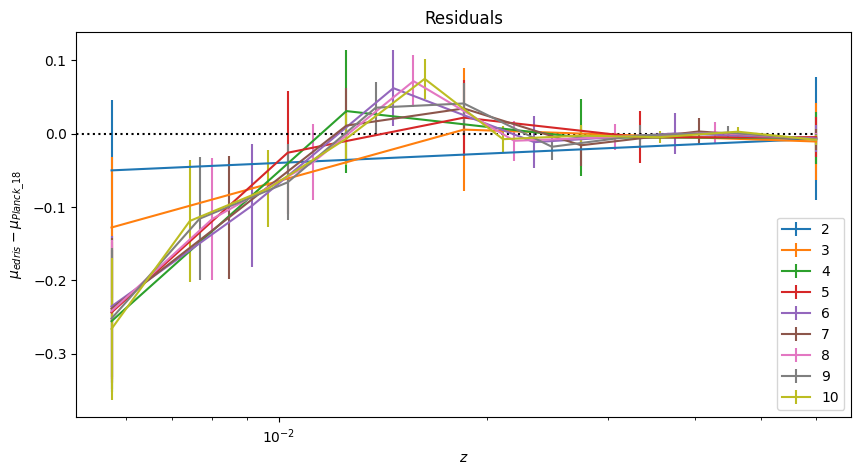

In [247]:
plt.figure('residuals', figsize=(10,5))
for bins, cov, res in zip(z_bins, covs, results):
    plt.errorbar(bins, res['mu_bins'] - (jnp.array(cosmo.distmod(np.array(bins))) - 19.3),
                 yerr=jnp.sqrt(jnp.diag(cov_res[2:2+len(bins),2:2+len(bins)])),
                 label=f'{len(bins)}')
plt.title('Residuals')
plt.xlabel("$z$")
plt.ylabel("$\mu_{edris} - \mu_{Planck\_18}$")
# plt.savefig(f'../figures/edris_{n}sn_bias.png')
plt.xscale('log')
plt.hlines(0,1e-4,0.06, linestyle='dotted', color='k')
plt.legend()

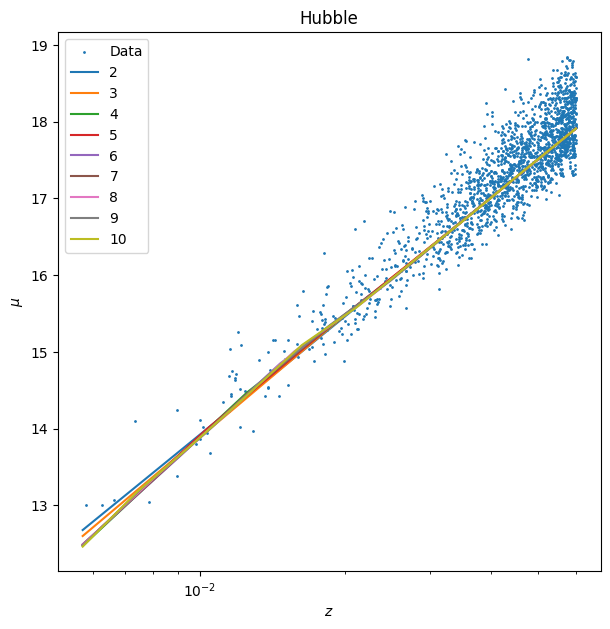

In [249]:
plt.figure('hubble', figsize=(7,7))
plt.scatter(exp['z'], obs.mag, s=1, label='Data')
for bins, res in zip(z_bins, results):
    plt.plot(bins, res['mu_bins'], label=f'{len(bins)}')
    plt.xscale("log")
    plt.title('Hubble')
    plt.xlabel("$z$")
    plt.ylabel("$\mu$")
    plt.legend()

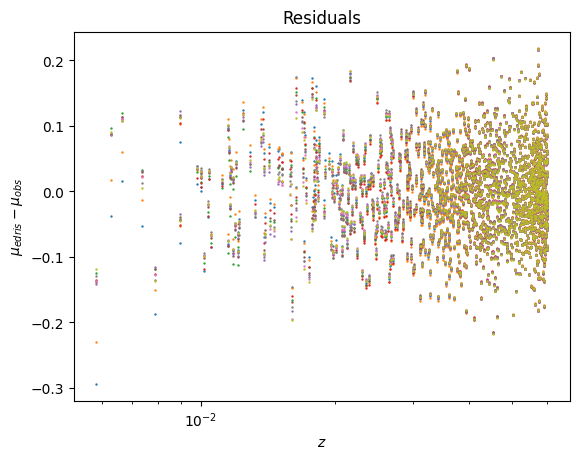

In [258]:
plt.figure('residuals')
for res,bins in zip(results,z_bins):
    plt.scatter(exp['z'], obs.mag-edris.models.sn1a_model(res, {'z_bins':bins, 'z':exp["z"]}).mag, s=.5, alpha=1)
plt.title('Residuals')
plt.xlabel("$z$")
plt.ylabel("$\mu_{edris} - \mu_{obs}$")
# plt.savefig(f'../figures/edris_{n}sn_bias.png')
plt.xscale('log')

### Fit

In [42]:
exp

{'z': Array([0.03537348, 0.03941092, 0.0505216 , ..., 0.05700946, 0.05981482,
        0.02114542], dtype=float64),
 'z_bins': Array([0.00572108, 0.00915404, 0.01464697, 0.02343595, 0.0374988 ,
        0.06000014], dtype=float64)}

In [267]:
jnp.digitize(obs.mag, res['mu_bins'])

Array([4, 5, 5, ..., 5, 6, 3], dtype=int32)

In [43]:
n = 1801
n_var=2
n_bins=6

In [45]:
err = jnp.sqrt(jnp.diag(cov_res)[n_var:n_bins+n_var])

In [46]:
from astropy.constants import c
from scipy.integrate import quad
from astropy.cosmology import Planck18 as cosmo
cosmo.Ogamma0 + cosmo.Onu0, cosmo.Om0, cosmo.Ode0, cosmo.H0.value

(0.0014936944554559178, 0.30966, 0.6888463055445441, 67.66)

In [47]:
def dist(z, Omega_r, Omega_m, Omega_l, H0):
    Omega_k = 1. - Omega_m - Omega_l - Omega_r
    return quad(lambda z1 : (Omega_m*(1+z1)**3 + Omega_r*(1+z1)**4 + Omega_k*(1+z1)**2 + Omega_l)**(-0.5)*c.value*10**(-3)/H0, 0, z)

dist_vec = np.vectorize(dist)

def f(z, Omega_m, Omega_r=cosmo.Ogamma0 + cosmo.Onu0, Omega_l=cosmo.Ode0, H0=cosmo.H0.value):
    return 5.0 * np.log10(abs((z + 1.0) * dist_vec(z, Omega_r, Omega_m, Omega_l, H0)[0])) + 25 -19.3

In [48]:
res['mu_bins']

Array([12.49380241, 13.65789404, 14.84751086, 15.80873311, 16.86370009,
       17.91242535], dtype=float64)

In [53]:
from scipy.optimize import curve_fit

popt, pcov, info, msg, ier = curve_fit(f,
                       exp['z_bins'],
                       res['mu_bins'],
                       sigma=cov_res[n_var:n_bins+n_var,n_var:n_bins+n_var],
                       p0=[cosmo.Om0],
                       bounds=([0.],[1.]),
                       full_output=True
                      )

In [58]:
popt, pcov

(array([0.42740587]), array([[0.06610365]]))

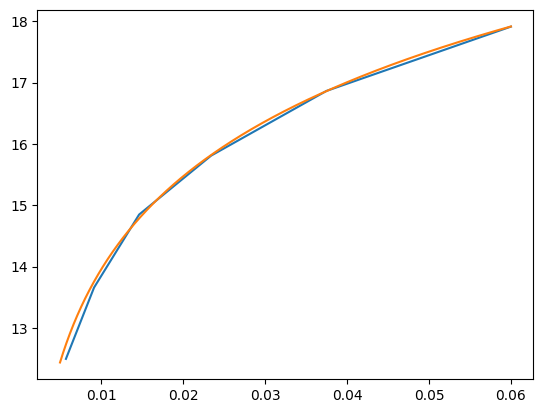

In [56]:
plt.plot(exp['z_bins'], res['mu_bins'])
plt.plot(np.linspace(5e-3, 0.06,1000), f(np.linspace(5e-3, 0.06,1000), *popt))

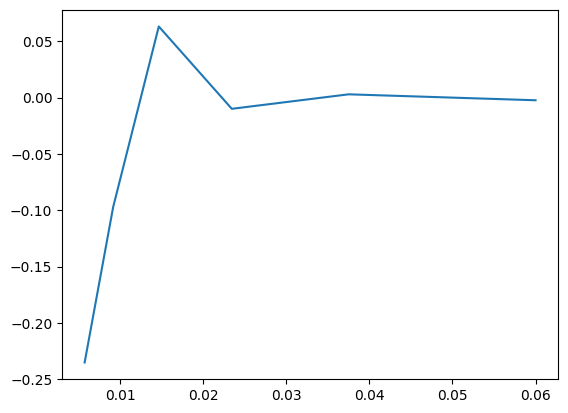

In [60]:
plt.plot(exp['z_bins'], res['mu_bins']-f(exp['z_bins'], *popt))

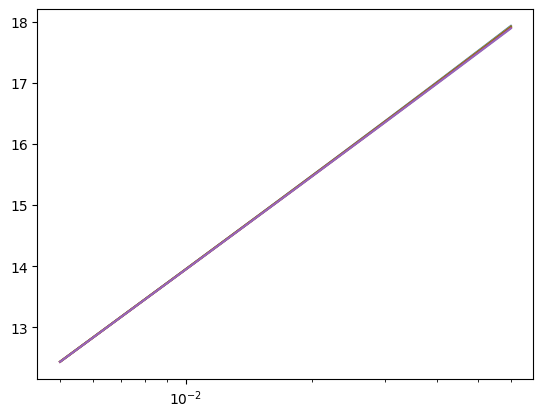

In [61]:
for popt in zip(0.1*np.arange(5),0.1*np.arange(5),):
    plt.plot(np.linspace(5e-3, 0.06,1000), f(np.linspace(5e-3, 0.06,1000), *popt))
plt.xscale("log")

In [63]:
info, msg, ier

({'nfev': 6,
  'fvec': array([ 3.14753324,  3.1355912 , -2.02310231, -0.00737547, -0.3393086 ,
          0.20311418])},
 '`ftol` termination condition is satisfied.',
 2)

In [282]:
from astropy.cosmology import z_at_value
z_cosmo = z_at_value(cosmo.distmod, (19.3+obs.mag)*u.mag).value

In [289]:
data_edris

redshift     x1      c            t0  ...  template  keep  good  converged
4      0.02845  0.480 -0.068  59145.472656  ...     salt2  True  True       True
5      0.05135 -1.765  0.120  58937.960938  ...     salt2  True  True       True
6      0.04675  0.160  0.051  58593.023438  ...     salt2  True  True       True
10     0.02505  0.960  0.038  58612.425781  ...     salt2  True  True       True
12     0.03845  0.290  0.011  58381.136719  ...     salt2  True  True       True
...        ...    ...    ...           ...  ...       ...   ...   ...        ...
4468   0.02245  0.125  0.058  58715.785156  ...     salt2  True  True       True
4470   0.05695  0.915 -0.028  58514.187500  ...     salt2  True  True       True
4471   0.03885  1.345 -0.028  58533.738281  ...     salt2  True  True       True
4472   0.02915 -0.020  0.152  58478.878906  ...     salt2  True  True       True
4477   0.05525  0.960 -0.064  59169.683594  ...     salt2  True  True       True

[1801 rows x 15 columns]

## Likelihood profiling

In [190]:
profile = lambda x,y : edris.models.likelihood({'mu_bins':jnp.array(cosmo.distmod(np.array(exp['z_bins']))) - 19.3,
      'coef': jnp.array([x,y]),
      'variables':jnp.array(obs.variables.reshape((2,-1 ))),
      'sigma_int':0.1},
        exp, cov_sel, obs, cosmo=edris.cosmo.binned_cosmo, truncated=False, restricted=False
)
profile=jnp.vectorize(profile)
profile=jax.jit(profile)

In [141]:
xx, yy = np.meshgrid(np.linspace(-.2,-.08, 1000), np.linspace(3.0,3.5,1000))

In [142]:
profile_L = profile(xx,yy)

In [143]:
profile_L.min()

Array(-6280.9726096, dtype=float64)

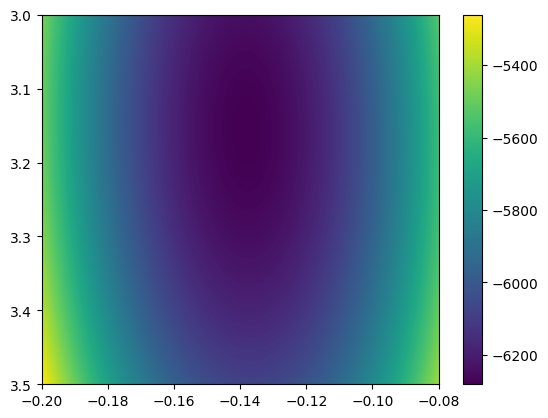

In [144]:
plt.imshow(profile_L, extent=[-.2,-.08,3.5,3], aspect='auto')
plt.colorbar()

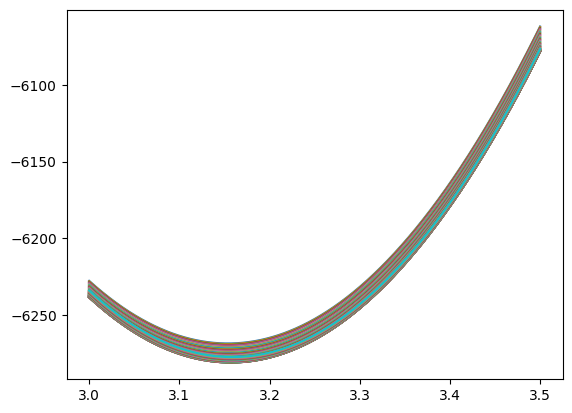

In [145]:
plt.figure()
_=plt.plot(yy[:,450:550], profile_L[:,450:550])

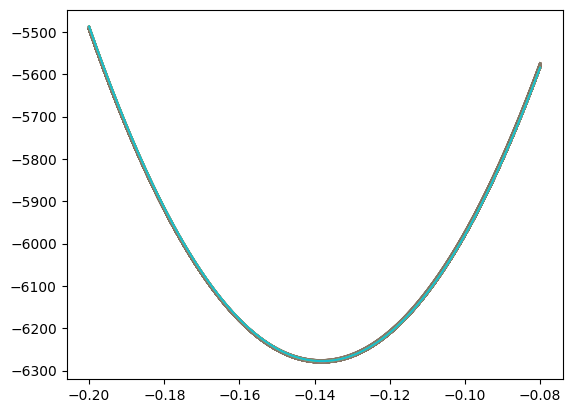

In [146]:
plt.figure()
_=plt.plot(xx[200:400,:].T, profile_L[200:400,:].T)

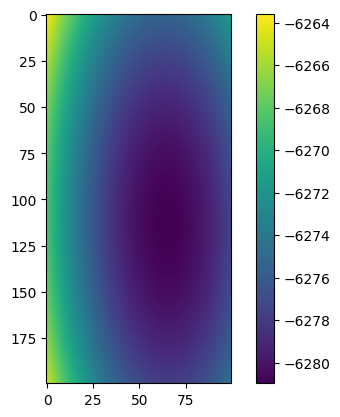

In [147]:
plt.figure()
plt.imshow(profile_L[200:400,450:550], cmap='viridis')
plt.colorbar()

In [190]:
profile = lambda x,y : edris.models.likelihood({'mu_bins':jnp.array(cosmo.distmod(np.array(exp['z_bins']))) - 19.3,
      'coef': jnp.array([x,y]),
      'variables':jnp.array(obs.variables.reshape((2,-1 ))),
      'sigma_int':0.1},
        exp, cov_sel, obs, cosmo=edris.cosmo.binned_cosmo, truncated=False, restricted=False
)
profile=jnp.vectorize(profile)
profile=jax.jit(profile)

In [141]:
xx, yy = np.meshgrid(np.linspace(-.2,-.08, 1000), np.linspace(3.0,3.5,1000))

In [142]:
profile_L = profile(xx,yy)

In [143]:
profile_L.min()

Array(-6280.9726096, dtype=float64)

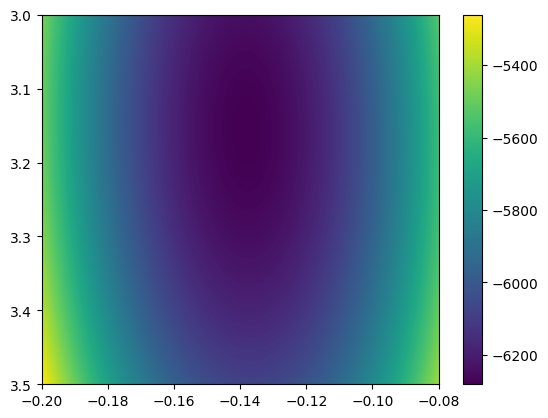

In [144]:
plt.imshow(profile_L, extent=[-.2,-.08,3.5,3], aspect='auto')
plt.colorbar()

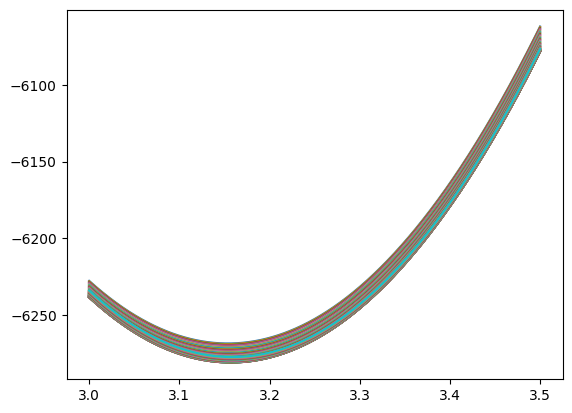

In [145]:
plt.figure()
_=plt.plot(yy[:,450:550], profile_L[:,450:550])

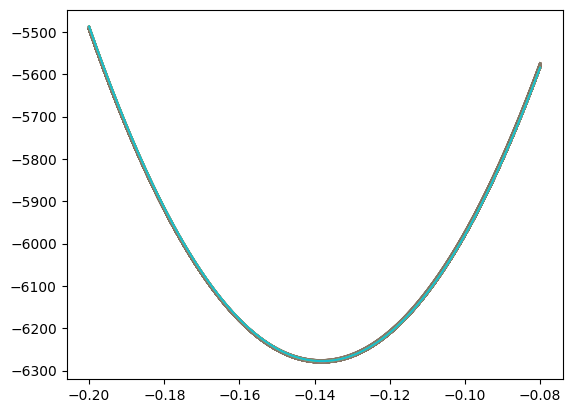

In [146]:
plt.figure()
_=plt.plot(xx[200:400,:].T, profile_L[200:400,:].T)

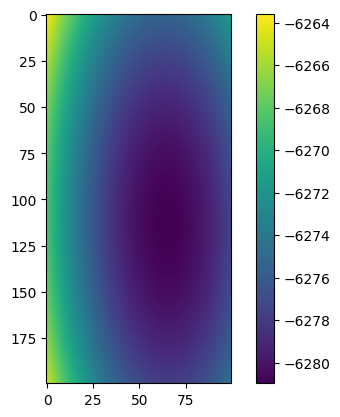

In [147]:
plt.figure()
plt.imshow(profile_L[200:400,450:550], cmap='viridis')
plt.colorbar()

# MOCKSURVEY

In [6]:
import sncosmo
from mocksurvey.simulations import *


In [16]:
with open("data/SN_Uchuu.pkl", 'rb') as f:
    lc = pickle.load(f)
    data = pickle.load(f)
    res_sn = pickle.load(f)

In [32]:
survey = extract_ztf()
snia = SNeIa_full_bgs()
snia.set_data(data)
dset = skysurvey.DataSet(data=lc, targets=snia, survey=survey)

In [43]:
detected = dset.targets.data[dset.targets.data["good"]].index

In [45]:
output = dset.data.loc[detected].join(dset.targets.data.loc[detected])

In [46]:
# output = get_detected_sn(dset, detlimit=7, detnumber= 10, per_band=False)
output = get_sn_index(output)
output = get_luminosity_distance(output, snia)
output = get_effective_wavelength(output)
output = eliminate_points_not_in_model(output, snia)
output = get_trueflux_and_amplitude(output, snia)
output = get_snr(output)

INFO:root:Getting SN indexes
INFO:root:Getting luminosity distances in Mpc
INFO:root:Getting effective wavelengths
INFO:root:Eliminating points not in model
INFO:root:Getting true fluxes and amplitudes
INFO:root:Getting snr


In [47]:
output = discard_small_snr(output, threshold=0)
output = discard_skysurvey_flux(output)

INFO:root:Discarding small snr
INFO:root:Getting SN indexes
INFO:root:discarding skysurvey flux


In [48]:
output['survey'] = 'ztf'

In [49]:
output.to_csv("tests.csv", encoding='utf-8', index=False)

In [50]:
from tqdm.auto import tqdm

In [51]:
def f(x, a, b, c):
    """
    """
    return a*x**2 + b*x + c


def generate_mock_sample(mock_ztf_path):
    """
    Generates the mock sample based on the generated mock survey.
    
    !! Need to generate the mock sample first
    
    Parameters:
    ------------
    mock_ztf_path : str
        Path to the generated ztf mock sample
    
    Returns:
    ------------
    : pandas.DataFrame
        Mock spectra
    
    """
    d_time = np.array([])
    d_wavelength = np.array([])
    d_flux = np.array([])
    d_fluxerr = np.array([])
    d_valid = np.array([])
    d_spec = np.array([])
    d_exptime = np.array([])
    d_snid = np.array([])
    d_flux_true = np.array([])
    d_x0 = np.array([])
    d_x1 = np.array([])
    d_c = np.array([])
    d_t0 = np.array([])
    d_mwebv = np.array([])
    d_z = np.array([])
    
    mock_survey = pd.read_csv(mock_ztf_path)
    idx = mock_survey['fluxtrue']!=0
    mock_survey = mock_survey[idx]
    
    mock_x0 = mock_survey['x0']
    mock_x1 = mock_survey['x1']
    mock_c = mock_survey['c']
    mock_t0 = mock_survey['t0']
    mock_z = mock_survey['z']
    mock_mwebv = mock_survey['mwebv']
    mock_snid = np.unique(mock_survey['snid'])
    
    
    n = len(mock_snid)
    length_wave = np.array([218, 437, 3258, 656, 868])
    popt = np.array([-7.87649259e-07,  1.08382223e-02, -2.44390307e+01])
    a, b, c = popt
    for i in tqdm(range(n)):
        x0 = np.array(mock_x0[mock_survey['snid']==i])[0]
        x1 = np.array(mock_x1[mock_survey['snid']==i])[0]
        c = np.array(mock_c[mock_survey['snid']==i])[0]
        t0 = np.array(mock_t0[mock_survey['snid']==i])[0]
        z = np.array(mock_z[mock_survey['snid']==i])[0]
        mwebv = np.array(mock_mwebv[mock_survey['snid']==i])[0]
        
        
        wave_size = np.random.choice(length_wave)
        min_wave = np.random.uniform(2900., 3400.)
        max_wave = np.random.uniform(9000., 11000.)
        wavelength = np.linspace(min_wave, max_wave, wave_size)
        mjd = np.random.choice(mock_survey['time'][mock_survey['snid']==i])
        
        source = sncosmo.get_source('salt2', version='2.4')
        dust = sncosmo.CCM89Dust()
        model = sncosmo.Model(source=source, effects=[dust], effect_names=['mw'], effect_frames=['obs'])
        
        p = {'z':z, 't0':t0, 'x0':x0, 'x1': x1, 'c': c, 'ebv':mwebv, 'r_v':3.1}
        model.parameters = list(p.values()) 
        
        
        min_w = model.minwave()
        max_w = model.maxwave()
        
        try:
            flux_true = model.flux(mjd, wavelength)
        except:
            try:
                flux_true = model.flux(mjd, wavelength[wavelength<max_w])
                wavelength = wavelength[wavelength<max_w]
            except:
                flux_true = model.flux(mjd, wavelength[wavelength>min_w])
                wavelength = wavelength[wavelength>min_w]
        #j = np.random.randint(0, N)
        #err_ = spec_data['fluxerr'][j]
        #flx_ = spec_data['flux'][j]
        #norm = flx_/np.max(flux_true)

        #if norm == norm and norm != np.inf and norm != -np.inf:
        #    flux_true *= norm
        #flux_err = err_*np.random.randn(len(flux_true))
        norm_values = np.array([1,1,1,1,1,1,1,1,1,1E+12])
        norm = np.random.choice(norm_values)
        flux_true *= norm
        flux_err = (flux_true/f(wavelength, a, b, c)) *np.random.randn(len(flux_true))
        flux = flux_true + 0.5*flux_err
        
        d_time = np.append(d_time, np.repeat(mjd, len(flux)))
        d_wavelength = np.append(d_wavelength, wavelength)
        d_flux = np.append(d_flux, flux)
        d_fluxerr = np.append(d_fluxerr, np.abs(flux_err))
        d_flux_true = np.append(d_flux_true, flux_true)
        d_valid = np.append(d_valid, np.repeat(1, len(flux)))
        d_exptime = np.append(d_exptime, np.repeat(np.nan, len(flux)))
        d_snid = np.append(d_snid, np.repeat(mock_snid[i], len(flux)))
        d_spec = np.append(d_spec, np.repeat(i, len(flux)))
        d_x0 = np.append(d_x0, np.repeat(x0, len(flux)))
        d_x1 = np.append(d_x1, np.repeat(x1, len(flux)))
        d_c = np.append(d_c, np.repeat(c, len(flux)))
        d_t0 = np.append(d_t0, np.repeat(t0, len(flux)))
        d_z = np.append(d_z, np.repeat(z, len(flux)))
        d_mwebv = np.append(d_mwebv, np.repeat(mwebv, len(flux)))
    data_sim = pd.DataFrame({'spec':d_spec, 'time': d_time, 
                             'wavelength': d_wavelength, 'flux': d_flux, 
                             'fluxerr': d_fluxerr, 'valid': d_valid, 
                             'spec': d_spec, 'exptime': d_exptime, 
                             'snid': d_snid, 'flux_true':d_flux_true,
                             'x0':d_x0, 'x1': d_x1, 'c':d_c, 't0':d_t0,
                             'mwebv':d_mwebv, 'z':d_z})
    return data_sim


In [52]:
data_mock = generate_mock_sample('tests.csv')
data_mock.to_csv('mock_ztf_spectra.csv')

  0%|          | 0/2843 [00:00<?, ?it/s]

In [ ]:
%matplotlib inline

In [ ]:
data_mock=pandas.read_csv('mock_ztf_spectra.csv')

In [ ]:
%matplotlib inline

for i in tqdm(data_mock.groupby("spec")["spec"].mean()[::100]):
    plt.errorbar(data_mock[data_mock['spec']==i]["wavelength"], data_mock[data_mock['spec']==i]["flux"], data_mock[data_mock['spec']==i]["fluxerr"], capsize=2)
    
plt.xlabel('wavelength')
plt.ylabel('flux')

# GEORGES

In [127]:
with open("data/SN_Uchuu.pkl", 'rb') as f:
    lc_ = pickle.load(f)
    data_ = pickle.load(f)
    res_sn_ = pickle.load(f)

In [128]:
index = np.unique(list(map(lambda x : x[0], res_sn.index)))

In [193]:
n = len(index)

covariances = {
    i: np.array(res_sn.loc[i].loc[["x0", "x1", "c"]][["cov_x0", "cov_x1", "cov_c"]])
    for i in index
}

stacked_res = pandas.DataFrame(
    {
        **{
            col: np.array(res_sn["value"].loc[map(lambda x: (x, col), index)])
            for col in ["x0", "x1", "c"]
        }
    },
    index=index,
)
full_cov = block_diag(*[cov[i] for i in cov.keys()])

In [194]:
test = data.join(stacked_res, lsuffix="_input")

In [195]:
test[test["good"]]

redshift  x1_input  c_input  ...        x0        x1         c
0      0.03785     0.075    0.142  ...  0.000752  0.378313  0.134977
3      0.05435     0.335    0.003  ...  0.002122 -0.559867 -0.043119
4      0.02845     0.480   -0.068  ...  0.004431  0.565483 -0.071906
5      0.05135    -1.765    0.120  ...  0.001377 -1.703276  0.119809
6      0.04675     0.160    0.051  ...  0.001368  0.126254  0.048758
...        ...       ...      ...  ...       ...       ...       ...
4470   0.05695     0.915   -0.028  ...  0.002705  0.904150 -0.027728
4471   0.03885     1.345   -0.028  ...  0.001528  1.446821 -0.040952
4472   0.02915    -0.020    0.152  ...  0.000576  1.411196  0.306838
4474   0.05735    -0.200    0.019  ...  0.003435 -0.834765  0.038290
4477   0.05525     0.960   -0.064  ...  0.012048  0.954561 -0.065186

[2842 rows x 17 columns]

In [197]:
full_cov.shape

(8526, 8526)

In [187]:
M0=10.501612
test["Mb"] = -2.5 * np.log10(values["x0"]) + M0

In [294]:
fit_params=["x0","x1","c"]

In [189]:
M = block_diag(*[np.diag([-2.5 / (np.log(10) * test["x0"].loc[i]), *np.ones_like(fit_params, dtype=float)[:-1]]) for i in test[test["good"]].index])

In [246]:
covariance=M@full_cov@M

In [251]:
len(covariance)

8526

In [252]:
len(fit_params)

3

In [254]:
n = int(len(covariance)/len(fit_params))

In [265]:
p=np.array([[len(fit_params)*i+k for i in range(n)]
             for k in range(len(fit_params))]).flatten()

In [266]:
p

array([   0,    3,    6, ..., 8519, 8522, 8525])

In [277]:
cov_test=covariance[:,p][p,:].copy()

In [287]:
data.rename({"good":"fitted"}, axis=1, inplace=True)

In [295]:
variables = fit_params.copy()
variables.remove("x0")
var = jnp.array([data[data["fitted"]][col].to_list() for col in variables]).flatten()
